# Tutorial for Functions.py

Minimization of the full loss function ($\alpha,\beta,\gamma$ hyperparameters) through nested minimization.

It includes also the optimization of force fields (corresponding to $\alpha,\gamma=\infty$) with data from alchemical $\Delta G$ calculations.

Customized algorithm.

- see https://pubs.aip.org/aip/jcp/article/158/21/214120/2894410 for refinement with only $\alpha,\gamma$ finite and https://pubs.acs.org/doi/full/10.1021/acs.jpclett.3c03423 for refinement with only $\alpha,\beta$ finite;

- see https://pubs.acs.org/doi/full/10.1021/acscentsci.2c00565 for refinement with alchemical calculations (L2 regularization).

In [1]:
import numpy as np
import jax.numpy as jnp
import pandas
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output

import from parent directory

In [2]:
import sys
sys.path.append('../')

In [3]:
from MDRefine import load_data, minimizer, select_traintest, hyper_minimizer, MDRefinement

a simple script to unwrap dictionaries:

In [4]:
def unwrap_dict(d):

    res = []
    
    if isinstance(d, dict):
        for val in d.values():
            res.extend(unwrap_dict(val))
    else:
        if isinstance(d, list): res = d
        else: res = [d]

    return np.hstack(res)

## 1. Ensemble refinement

### a. Load data
Define **infos** dictionary, which specifies required information in order to get data from input files through **load_data**.

see also load_data.ipynb

#### Load observables
(e.g., no force-field terms and no forward quantities)

In [5]:
infos = {}

# Firstly, define global properties, valid for all the systems:

infos['global'] = {}

# 'name of the folder with data'
infos['global']['path_directory'] = '../../DATA'

# system names
system_names = ['AAAA', 'CAAU']  # , 'CCCC', 'GACC', 'UUUU', 'UCAAUC']
infos['global']['system_names'] = system_names

# Then, define properties which are specific of each system, like experimental data and observables

for name in system_names:
    infos[name] = {}
    
    # experimental observables (average and uncertainty), corresponding to 'file_name'.npy in DATA/system_name/g_exp/
    # uNOEs values are upper bounds, so specify '<' with ('uNOEs','<')
    infos[name]['g_exp'] = ['NOEs', ('uNOEs','<')]
    
    # observables from MD simulations, corresponding to 'file_name'.npy in DATA/system_name/observables/
    # they must correspond also to items of infos[name]['g_exp']
    infos[name]['obs'] = ['NOEs', 'uNOEs']

# If some properties are the same for all the systems, you can store them just once in infos['global']

infos['global']['temperature'] = 1 # namely, energies are in unit of k_B T (default value)
# (in this case, you could do this also for 'g_exp' and 'obs')

# Select the stride for the frames (thinner strides will require more time for minimizations; default value = 1)
stride = 1000

In [6]:
data = load_data(infos, stride = stride)

loading data from directory...
loading  AAAA
loading  CAAU
loading  CCCC
loading  GACC
loading  UUUU
loading  UCAAUC
done


#### Include also quantities computed through a **forward model**.

Besides previously defined **infos**:

In [7]:
for name in system_names:
    # include experimental values also for 3J scalar couplings
    infos[name]['g_exp'] = ['backbone1_gamma_3J', 'backbone2_beta_epsilon_3J', 'sugar_3J', 'NOEs', ('uNOEs','<')]

    # include quantities required to compute observables through the forward model
    # they must correspond to 'file_name'.npy in DATA/system_name/forward_qs/
    infos[name]['forward_qs'] = ['backbone1_gamma','backbone2_beta_epsilon','sugar']

# starting values of the forward model coefficients: specify the file name inside DATA/
infos['global']['forward_coeffs'] = 'original_fm_coeffs' # string

Now, define the **forward_model**.

In our case-study, the forward model is given by the **Karplus equations**:

$^3 J_\gamma = A_\gamma \, cos^2\gamma \, + \, B_\gamma \, cos\gamma \, + \, C_\gamma$

with empirical coefficients $A_\gamma,\,B_\gamma,\,C_\gamma$ ($\gamma$ dihedral angles), and analogously for $^3 J_{\beta/\epsilon}$ (same coefficients both for $\beta$ and $\epsilon$ dihedral angles) and $^3J_\nu$ (sugar dihedral angles).

**WARNING**: keys of **forward_qs_out** must correspond to associated g_exp, as specified in infos

In [8]:
def forward_model_fun(fm_coeffs, forward_qs, selected_obs = None):

    # 1. compute the cosine (which is the quantity you need in the forward model;
    # you could do this just once before loading data)
    forward_qs_cos = {}

    for type_name in forward_qs.keys():
        forward_qs_cos[type_name] = np.cos(forward_qs[type_name])

    # if you have selected_obs, compute only the corresponding observables
    if selected_obs is not None:
        for type_name in forward_qs.keys():
            forward_qs_cos[type_name] = forward_qs_cos[type_name][:,selected_obs[type_name+'_3J']]

    # 2. compute observables (forward_qs_out) through forward model
    forward_qs_out = {
        'backbone1_gamma_3J': fm_coeffs[0]*forward_qs_cos['backbone1_gamma']**2 + fm_coeffs[1]*forward_qs_cos['backbone1_gamma'] + fm_coeffs[2],
        'backbone2_beta_epsilon_3J': fm_coeffs[3]*forward_qs_cos['backbone2_beta_epsilon']**2 + fm_coeffs[4]*forward_qs_cos['backbone2_beta_epsilon'] + fm_coeffs[5],
        'sugar_3J': fm_coeffs[6]*forward_qs_cos['sugar']**2 + fm_coeffs[7]*forward_qs_cos['sugar'] + fm_coeffs[8]}

    return forward_qs_out

same forward-model function for each system, so put it in infos['global']

In [9]:
infos['global']['forward_model'] = forward_model_fun

In [10]:
data = load_data(infos, stride = stride)

loading data from directory...
loading  AAAA
loading  CAAU
loading  CCCC
loading  GACC
loading  UUUU
loading  UCAAUC
done


### b. Minimize the loss function and analyse the results
for a single choice of the hyper-parameter $\alpha$

In [28]:
# use function minimizer with selected data and alpha as input
Result = minimizer(data, alpha=1)

Let's look at the values contained in the class **Result**

In [13]:
print(vars(Result).keys())

dict_keys(['loss', 'min_lambdas', 'minis', 'time', 'D_KL_alpha', 'abs_difference', 'av_g', 'chi2', 'logZ_new', 'weights_new'])


**Comments on the minimization.**

As shown in *Andrea Cesari et al., JCTC 2016*, the optimal ensemble $P$ which minimizes the loss function

$\mathcal{L}[P] = \frac{1}{2}\chi^2[P]+\alpha D_{KL}[P|P_0]$

is $P_{\vec\lambda^*}(x) = \frac{1}{Z_{\vec\lambda^*}} P_0(x) e^{-\vec\lambda^*\cdot\vec g(x)}$ where $\vec\lambda^*$ is the point of minimum of the following function

$\Gamma(\vec\lambda) = \frac{1}{2}\alpha\sum_j\sigma_j^2\lambda_j^2+\log Z_{\vec\lambda}+\vec\lambda\cdot\vec{g}_{exp},$

which fulfils $\mathcal L(P_{\vec\lambda^*}) = -\alpha\Gamma(\vec\lambda^*)$ and

$\lambda_i^* = \frac{\langle g_i \rangle_{P_*}-g_{i,exp}}{\alpha\sigma_{i,exp}^2}$.

The Python function **minimizer** exploits this relationship by minimizing $\Gamma$ (for each system), and then evaluating in detail $\mathcal{L}[P_\lambda]$ at the optimal point found for $\Gamma$ (in order to get $\chi^2$ and $D_{KL}$). To check the success of the minimization of $\Gamma$, you can read the truth value *success of inner minimization* (output message of scipy.optimize.minimize, in **Result.minis[name_sys].success**). The quality of this result is determined by comparing $-\alpha\Gamma(\vec\lambda^*)$ with $\mathcal L(P_{\vec\lambda^*})$, which we know to be equal at the point of minimum; this is reported in **Result.abs_difference**.

In [19]:
for name_sys in data['global'].system_names:
    print(Result.minis[name_sys].success, Result.minis[name_sys].message)

print('\nabsolute differences:\n', Result.abs_difference)

True Optimization terminated successfully.
True Optimization terminated successfully.

absolute differences:
 {'AAAA': DeviceArray(0.00567539, dtype=float64), 'CAAU': DeviceArray(0.00401629, dtype=float64)}


- first of all, the min. value of the loss function **loss**

In [20]:
print('optimal loss: ', Result.loss)
print('time required: ', Result.time)

optimal loss:  157.40786286559697
time required:  22.592878818511963


- then, the optimal ensembles $P^*$ **weights_new** (completely defined by the starting ensembles and by the **min_lambdas** coefficients), together with their (log) normalization factor **logZ_new**. Let's plot them.

Their statistical robustness is evaluated by the Kullback-Leibler divergence from the initial ensembles **D_KL_alpha** as $e^{-D_{KL}[P^*|P_0]}$ (geometric average of the ratio $P^*(x)/P_0(x)$, averaged over $P^*(x)$). Notice the arithmetic average is the effective n. of frames (compared to the total n.), defined as the inverse of the Kish size
$\frac{n_{eff}}{N} = \frac{1}{N\sum_t w_t^2}$).

In [21]:
Result.D_KL_alpha

{'AAAA': DeviceArray(3.82488963, dtype=float64),
 'CAAU': DeviceArray(4.19595699, dtype=float64)}

system AAAA:
effective n. of frames (on the total n.):  0.02182084373353677
logZ:  -268.01362443341077
system CAAU:
effective n. of frames (on the total n.):  0.01505632676196905
logZ:  -222.45035438867598


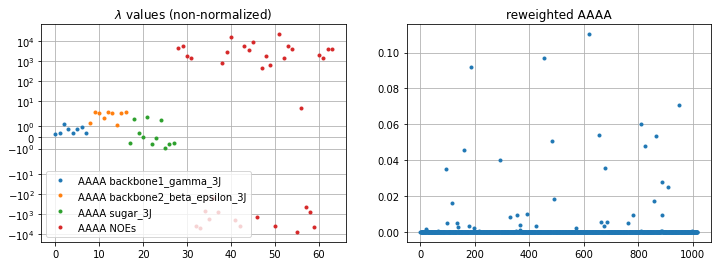

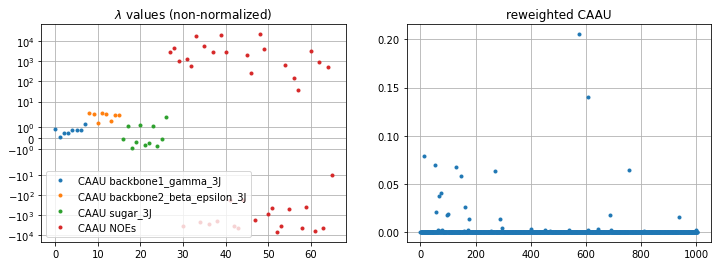

In [22]:
for s in system_names:

    plt.figure(figsize = (12,4))

    plt.subplot(1,2,1)

    l = 0
    for i2,s2 in enumerate(Result.min_lambdas[s].keys()):
        l_new = l+len(Result.min_lambdas[s][s2])
        plt.plot(np.arange(l,l_new),Result.min_lambdas[s][s2],'.',label='%s %s' % (s,s2))
        l = l_new

    plt.title('$\lambda$ values (non-normalized)')
    plt.legend()# loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid()
    plt.yscale('symlog')

    plt.subplot(1,2,2)
    
    plt.plot(Result.weights_new[s],'.')
    plt.title('reweighted %s' % s)
    plt.grid()
    
    n_eff = np.exp(-Result.D_KL_alpha[s])

    print('system %s:' % s)
    print('effective n. of frames (on the total n.): ', n_eff)
    print('logZ: ', Result.logZ_new[s])


- finally, let's look at the average values of the observables in the new ensembles **av_g** and associated **chi2**; compare with experimental values data.gexp and with average values of the original ensembles.

chi2:  17.464389378171056
observables (first names in list):
 [["A1-H1'" 'A1-H8']
 ["A1-H1'" 'A2-H8']
 ['A1-H2' "A2-H1'"]
 ["A1-1H2'" 'A1-H8']
 ["A1-1H2'" "A2-H1'"]]


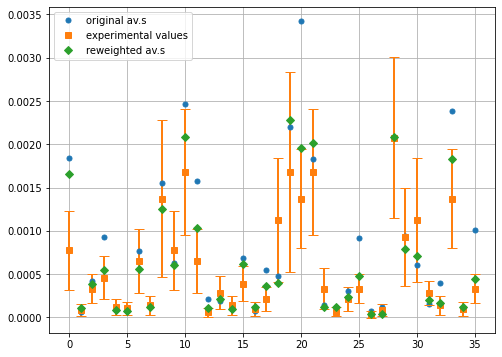

In [23]:
s1 = 'AAAA'
s2 = 'NOEs'

print('chi2: ',Result.chi2[s1][s2])
print('observables (first names in list):\n',data[s1].names[s2][:5])

plt.figure(figsize=(8,6))

# compute average values with original ensemble
g_mean = np.matmul(data[s1].weights, data[s1].g[s2])

plt.plot(g_mean,'.',label='original av.s',markersize=10)

plt.plot(data[s1].gexp[s2][:,0],'s',label='experimental values')
plt.errorbar(np.arange(len(data[s1].gexp[s2][:,0])), data[s1].gexp[s2][:,0], data[s1].gexp[s2][:,1], fmt = ' ',
    color = 'tab:orange', capsize = 5, lw = 2)

plt.plot(Result.av_g[s1][s2], 'D', label = 'reweighted av.s')

plt.legend()
plt.grid()

### c. Determine optimal hyper parameter $\alpha$ through cross validation (scan over $\alpha$)

The loss function for Ensemble Refinement, previously introduced, has one hyper-parameter $\alpha$ which needs to be fixed. This hyper-parameter tunes the reliability given to the original ensemble in spite of the trust to experimental data.

Suitable values of $\alpha$ can be determined through cross validation procedure: randomly split the full data set into training and test set, then select the value of $\alpha$ which minimizes the $\chi^2$ on the test set (either same observables as in training but new frames or new observables).

Let's perform just one splitting into training/test set (as an example) and scan over different values of $\alpha$ (in logarithmic scale).

The function **select_traintest** can be used to get **data_train** and **data_test** by simply passing a **random_state** (a random integer), which randomly selects **test_obs** and **test_frames**.

In [11]:
data_train, data_test, test_obs, test_frames = select_traintest(data, random_state=1)

Input random_state employed both for test_obs and test_frames


In [12]:
vars(data['AAAA']).keys()

dict_keys(['temperature', 'gexp', 'names', 'ref', 'g', 'forward_model', 'forward_qs', 'weights', 'n_experiments', 'n_frames'])

In [13]:
n_uNOEs = 0

for name in data['global'].system_names:
    n_uNOEs += data[name].n_experiments['uNOEs']

n_uNOEs

2016

In [14]:
n_tot_exp = data['global'].tot_n_experiments(data)
n_test_exp = len(unwrap_dict(test_obs))

n_train_exp = n_tot_exp - n_test_exp

print(n_tot_exp, n_test_exp, n_train_exp)

2384 478 1906


In [15]:
print('test observables:\n', test_obs)
print('test frames:\n', test_frames)

test observables:
 {'AAAA': {'backbone1_gamma_3J': DeviceArray([4], dtype=int64), 'backbone2_beta_epsilon_3J': DeviceArray([3, 7], dtype=int64), 'sugar_3J': DeviceArray([0, 8], dtype=int64), 'NOEs': DeviceArray([ 1, 15, 19, 23, 24, 25], dtype=int64), 'uNOEs': DeviceArray([  3,   6,  10,  15,  16,  18,  21,  30,  44,  46,  47,  50,
              56,  65,  81,  86,  92,  94,  99, 101, 109, 112, 114, 116,
             119, 122, 126, 134, 135, 138, 144, 155, 157, 162, 164, 169,
             177, 180, 182, 185, 187, 194, 212, 214, 216, 217, 223, 224,
             225, 238, 243], dtype=int64)}, 'CAAU': {'backbone2_beta_epsilon_3J': DeviceArray([0, 2, 3], dtype=int64), 'sugar_3J': DeviceArray([2, 4], dtype=int64), 'NOEs': DeviceArray([ 0,  6,  8, 13, 15, 24, 25, 26, 30, 33], dtype=int64), 'uNOEs': DeviceArray([  1,   3,   5,  23,  30,  45,  47,  60,  61,  62,  64,  74,
              80,  89,  96,  98, 112, 115, 118, 122, 123, 124, 125, 127,
             128, 129, 130, 135, 136, 137, 141, 144,

Default values for the fraction of test observables and frames are $20\%$ for both (you can change this ratio by selecting **test_frames_size** and/or **test_obs_size** as input variables). By default, test observables are evaluated only on test frames; you can also consider both on training and test frames, by setting **if_all_frames** = True.

In [25]:
data_train, data_test, test_obs, test_frames = select_traintest(data, test_frames_size = 0.2, test_obs_size = 0.3,
    random_state = 4, if_all_frames = True)

Input random_state employed both for test_obs and test_frames


({'global': <Functions.load_data.<locals>.data_global_class at 0x7f3a654e9f28>,
  'AAAA': Functions.select_traintest.<locals>.class_train,
  'CAAU': Functions.select_traintest.<locals>.class_train},
 {'global': <Functions.load_data.<locals>.data_global_class at 0x7f3a654e9f28>,
  'AAAA': Functions.select_traintest.<locals>.class_test,
  'CAAU': Functions.select_traintest.<locals>.class_test},
 {'AAAA': {'backbone1_gamma_3J': DeviceArray([1, 2, 3, 5], dtype=int64),
   'backbone2_beta_epsilon_3J': DeviceArray([1], dtype=int64),
   'sugar_3J': DeviceArray([0, 2, 3, 7], dtype=int64),
   'NOEs': DeviceArray([ 2,  3,  5, 22, 25, 26, 27, 29, 30, 32], dtype=int64)},
  'CAAU': {'backbone1_gamma_3J': DeviceArray([0, 2, 3], dtype=int64),
   'backbone2_beta_epsilon_3J': DeviceArray([0, 2, 3, 4], dtype=int64),
   'sugar_3J': DeviceArray([0, 2, 3, 8], dtype=int64),
   'NOEs': DeviceArray([ 8, 11, 14, 23, 28, 30, 35, 36, 38], dtype=int64)}},
 {'AAAA': DeviceArray([   4,   23,   31,   36,   38,   43, 

Alternatively, we can also directly pass test_obs and test_frames.

In [44]:
out = select_traintest(data, test_obs = test_obs, test_frames = test_frames)

data_train = out[0]
data_test = out[1]

Now, let's scan over different values of $\alpha$ for a given partition of the full data set into training and test set. Let's work directly with logarithms in base 10, to explore several orders of magnitude for $\alpha$.

We can also pass data_test as input to minimizer: after the minimization of the loss function on data_train, we evaluate corresponding properties (such as $D_{KL}$, $\chi^2$, loss function) on test frames and $\chi^2$ on test observables.

In [9]:
log10_alphas = np.arange(-2, 7, 1)

Results = {}

for log10_alpha in log10_alphas:
    print(log10_alpha)

    alpha = 10**np.float64(log10_alpha)
    Results[log10_alpha] = minimizer(data_train, alpha=alpha, data_test=data_test)

    clear_output()

In [10]:
vars(Results[log10_alpha]).keys()

dict_keys(['loss', 'min_lambdas', 'minis', 'time', 'D_KL_alpha', 'abs_difference', 'av_g', 'chi2', 'logZ_new', 'weights_new', 'loss_test', 'D_KL_alpha_test', 'abs_difference_test', 'av_g_test', 'chi2_test', 'logZ_new_test', 'weights_new_test', 'avg_new_obs', 'chi2_new_obs'])

For each value of the hyper-parameter, we now have corresponding quantities for test frames (such as **loss_test**, **D_KL_alpha_test**, **av_g_test**, **chi2_test**, **weights_new_test**) and for test observables (**avg_new_obs** and **chi2_new_obs**).

Let's compare the loss function for training set and test set (new frames):
- at high values of $\alpha$, the two values almost overlap;
- decreasing $\alpha$, both the two loss functions decrease, except that the one on the test at a certain point starts to increase marking overfitting.

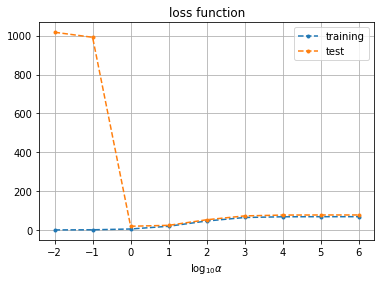

In [11]:
loss = [Results[log10_alpha].loss for log10_alpha in log10_alphas]
loss_test = [Results[log10_alpha].loss_test for log10_alpha in log10_alphas]

plt.title('loss function')
plt.plot(log10_alphas, loss, '.--', label = 'training')
plt.plot(log10_alphas, loss_test, '.--', label = 'test')
plt.xlabel(r'$\log_{10}\alpha$')
plt.legend()
plt.grid()

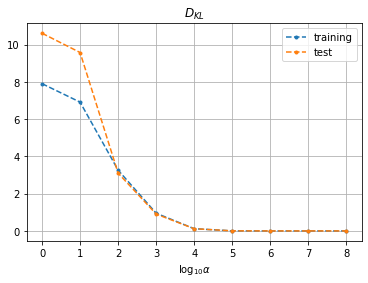

In [12]:
D_KL_train = [np.sum(unwrap_dict(Results[log10_alpha].D_KL_alpha)) for log10_alpha in log10_alphas]
D_KL_test = [np.sum(unwrap_dict(Results[log10_alpha].D_KL_alpha_test)) for log10_alpha in log10_alphas]

plt.title('$D_{KL}$')
plt.plot(D_KL_train, '.--', label = 'training')
plt.plot(D_KL_test, '.--', label = 'test')
plt.xlabel(r'$\log_{10}\alpha$')
plt.legend()
plt.grid()

Now, the $\chi^2$, including also test observables

In [13]:
chi2s = [np.sum(unwrap_dict(Results[log10_alpha].chi2)) for log10_alpha in log10_alphas]
n_obs_train = data_train['global'].tot_n_experiments(data_train)

red_chi2s = np.array(chi2s)/n_obs_train

chi2s_test1 = [np.sum(unwrap_dict(Results[log10_alpha].chi2_test)) for log10_alpha in log10_alphas] # .chi2_test
red_chi2s_test1 = np.array(chi2s_test1)/n_obs_train

chi2s_test2 = [np.sum(unwrap_dict(Results[log10_alpha].chi2_new_obs)) for log10_alpha in log10_alphas] # .chi2_test
n_obs_test = len(unwrap_dict(test_obs))

red_chi2s_test2 = np.array(chi2s_test2)/n_obs_test

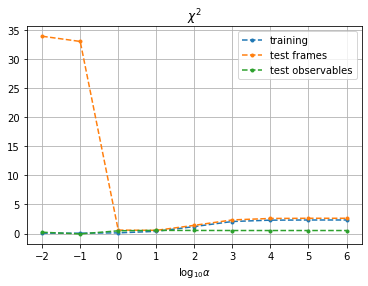

In [14]:
plt.plot(log10_alphas, red_chi2s, '.--', label = 'training')
plt.plot(log10_alphas, red_chi2s_test1, '.--', label = 'test frames')
plt.plot(log10_alphas, red_chi2s_test2, '.--', label = 'test observables')

plt.legend()
plt.title('$\chi^2$')
plt.xlabel(r'$\log_{10}\alpha$')
plt.grid()

### d. Determine optimal hyper parameter $\alpha$ through cross validation (automatic optimization)

Rather than performing a scan over the hyper-parameter $\alpha$, we now minimize the $\chi^2$ on the test set (computed at optimal parameters obtained in training) with respect to $\alpha$.

In [9]:
starting_alpha = 1e2

by default, which_set = 'validation' (rather than 'test' or 'training'), namely evaluate $\chi^2$ on same observables as training but new frames of the trajectory

In [10]:
mini = hyper_minimizer(data, starting_alpha = starting_alpha, random_states = 2, which_set = 'validation', gtol = 0.5)

Input random_state employed both for test_obs and test_frames
Input random_state employed both for test_obs and test_frames
log10 hyperpars:  [DeviceArray(2., dtype=float64)] ['alpha']
tot chi2:  179.99748935099893
tot gradient:  [164.58212585]
log10 hyperpars:  [2.] ['alpha']
tot chi2:  179.99748935099893
tot gradient:  [164.58212585]
log10 hyperpars:  [0.99] ['alpha']
tot chi2:  425.00547800983844
tot gradient:  [-1826.18114941]
log10 hyperpars:  [1.6329151] ['alpha']
tot chi2:  126.70090220074779
tot gradient:  [103.53961778]
log10 hyperpars:  [1.01026981] ['alpha']
tot chi2:  390.70284260061294
tot gradient:  [-1677.36149732]
log10 hyperpars:  [1.50044572] ['alpha']
tot chi2:  117.71717904095316
tot gradient:  [21.76320493]
log10 hyperpars:  [1.46519156] ['alpha']
tot chi2:  117.56919878055263
tot gradient:  [-12.86928899]
log10 hyperpars:  [1.47829186] ['alpha']
tot chi2:  117.4288039078597
tot gradient:  [1.38731611]
log10 hyperpars:  [1.47701706] ['alpha']
tot chi2:  117.4525033

In [11]:
mini

      fun: 117.4074816543556
 hess_inv: array([[0.00122096]])
      jac: array([-0.31450289])
  message: 'Optimization terminated successfully.'
     nfev: 12
      nit: 6
     njev: 12
   status: 0
  success: True
        x: array([1.47659801])

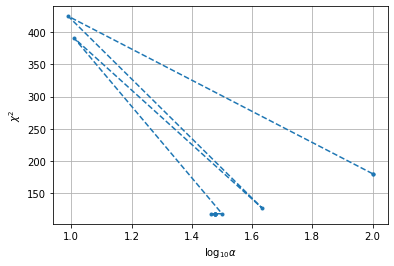

In [24]:
x = mini['intermediate'].log10_hyperpars
y = mini['intermediate'].av_chi2

plt.plot(x,y,'.--')
plt.xlabel(r'$\log_{10}\alpha$')
plt.ylabel('$\chi^2$')
plt.grid()

In [18]:
optimal_alpha = 10**(mini.x)

The optimal hyper-parameter is $\alpha \simeq 10^{1.09}$. We can now minimize the loss function on the whole data set in order to get more statistically robust results. Provided the estimation of the optimal hyper-parameters is robust enough, we can load the full data set without stride (it will take more time).

In [19]:
data = load_data(infos)

loading data from directory...
loading  AAAA
loading  CAAU
done


In [20]:
Result = minimizer(data, alpha = optimal_alpha)

In [21]:
vars(Result)

{'loss': DeviceArray([40.16542256], dtype=float64),
 'min_lambdas': {'AAAA': {'NOEs': DeviceArray([ 150.73992103,  -67.29285849,  105.62119535,  118.96876618,
                 -74.04540148, -102.87904109,   37.76755821,  -23.09866382,
                  10.40497866,  -30.11556459,   47.2407546 ,   97.55062434,
                1033.66361603,  -76.13445458, -119.69251423,  182.8412221 ,
                 -41.69269727,  349.17365518,  -39.84692591,   15.85069759,
                  91.86738887,   23.85272636,  -97.62859541,  614.99665463,
                 154.34680669,  303.89155513,  402.68529294,  191.27067489,
                  -1.15469979,  -20.86065066,  -19.20484019, -155.03477145,
                 169.41074214,   62.59969065,  106.82633384,  347.63227384],            dtype=float64)},
  'CAAU': {'NOEs': DeviceArray([ 116.99604616,   28.40984552,   54.57910406, -160.33853852,
                   7.83028943,   63.83780474,  502.50050988,  -83.25424726,
                 -11.50902254, -123.

Look at section b) for analysis of Result.

### do all together

In [22]:
Result = MDRefinement(infos, stride = stride, starting_alpha = 1e2, random_states = 2, which_set = 'validation', gtol = 0.5)

loading data from directory...
loading  AAAA
loading  CAAU
done

search for optimal hyperparameters ...
Input random_state employed both for test_obs and test_frames
Input random_state employed both for test_obs and test_frames
log10 hyperpars:  [DeviceArray(2., dtype=float64)] ['alpha']
tot chi2:  179.99748935099893
tot gradient:  [164.58212585]
log10 hyperpars:  [2.] ['alpha']
tot chi2:  179.99748935099893
tot gradient:  [164.58212585]
log10 hyperpars:  [0.99] ['alpha']
tot chi2:  425.00547800983844
tot gradient:  [-1826.18114941]
log10 hyperpars:  [1.6329151] ['alpha']
tot chi2:  126.70090220074779
tot gradient:  [103.53961778]
log10 hyperpars:  [1.01026981] ['alpha']
tot chi2:  390.70284260061294
tot gradient:  [-1677.36149732]
log10 hyperpars:  [1.50044572] ['alpha']
tot chi2:  117.71717904095316
tot gradient:  [21.76320493]
log10 hyperpars:  [1.46519156] ['alpha']
tot chi2:  117.56919878055263
tot gradient:  [-12.86928899]
log10 hyperpars:  [1.47829186] ['alpha']
tot chi2:  117.4

In [23]:
vars(Result)

{'loss': DeviceArray(40.16542256, dtype=float64),
 'min_lambdas': {'AAAA': {'NOEs': DeviceArray([ 150.73992103,  -67.29285849,  105.62119535,  118.96876618,
                 -74.04540148, -102.87904109,   37.76755821,  -23.09866382,
                  10.40497866,  -30.11556459,   47.2407546 ,   97.55062434,
                1033.66361603,  -76.13445458, -119.69251423,  182.8412221 ,
                 -41.69269727,  349.17365518,  -39.84692591,   15.85069759,
                  91.86738887,   23.85272636,  -97.62859541,  614.99665463,
                 154.34680669,  303.89155513,  402.68529294,  191.27067489,
                  -1.15469979,  -20.86065066,  -19.20484019, -155.03477145,
                 169.41074214,   62.59969065,  106.82633384,  347.63227384],            dtype=float64)},
  'CAAU': {'NOEs': DeviceArray([ 116.99604616,   28.40984552,   54.57910406, -160.33853852,
                   7.83028943,   63.83780474,  502.50050988,  -83.25424726,
                 -11.50902254, -123.38

## 2. Force-field refinement

### a. Load data

Load experimental data, observables and forward model as previously done.

Load also force-field correction terms and corresponding functional form.

In [17]:
infos = {}

# Define global properties, valid for all the systems:
infos['global'] = {}
infos['global']['path_directory'] = '../../DATA'
infos['global']['system_names'] = ['AAAA','CCCC','GACC','UUUU','UCAAUC']

# Then, define properties which are specific of each system, like experimental data and observables
# If some properties are the same for all the systems, you can store them just once in infos['global']
infos['global']['g_exp'] = ['backbone1_gamma_3J', 'backbone2_beta_epsilon_3J', 'sugar_3J', 'NOEs', ('uNOEs','<')]
infos['global']['forward_qs'] = ['backbone1_gamma','backbone2_beta_epsilon','sugar']
infos['global']['obs'] = ['NOEs','uNOEs']
infos['global']['forward_coeffs'] = 'original_fm_coeffs'

# Select the stride for the frames
stride = 1000

In [18]:
def forward_model_fun(fm_coeffs, forward_qs, selected_obs=None):

    # 1. compute the cosine (which is the quantity you need in the forward model;
    # you could do this just once before loading data)
    forward_qs_cos = {}

    for type_name in forward_qs.keys():
        forward_qs_cos[type_name] = np.cos(forward_qs[type_name])

    # if you have selected_obs, compute only the corresponding observables
    if selected_obs is not None:
        for type_name in forward_qs.keys():
            forward_qs_cos[type_name] = forward_qs_cos[type_name][:,selected_obs[type_name+'_3J']]

    # 2. compute observables (forward_qs_out) through forward model
    forward_qs_out = {
        'backbone1_gamma_3J': fm_coeffs[0]*forward_qs_cos['backbone1_gamma']**2 + fm_coeffs[1]*forward_qs_cos['backbone1_gamma'] + fm_coeffs[2],
        'backbone2_beta_epsilon_3J': fm_coeffs[3]*forward_qs_cos['backbone2_beta_epsilon']**2 + fm_coeffs[4]*forward_qs_cos['backbone2_beta_epsilon'] + fm_coeffs[5],
        'sugar_3J': fm_coeffs[6]*forward_qs_cos['sugar']**2 + fm_coeffs[7]*forward_qs_cos['sugar'] + fm_coeffs[8] }

    return forward_qs_out

same forward-model function for each system, so put it in infos['global']

In [19]:
infos['global']['forward_model'] = forward_model_fun

Now, the force-field correction terms: we selected (for each molecule)
\begin{equation}
\beta\Delta V = \sum_{i}\Bigl[\phi_1\cos\alpha_i + \phi_2\sin\alpha_i + \phi_3 \cos \zeta_i + \phi_4 \sin\zeta_i\Bigr]
\end{equation}
where the sum is over residues. Since numpy arrays ff_terms have columns

['sinalpha[0]', 'sinalpha[1]', 'sinalpha[2]', 'sinzeta[0]', 'sinzeta[1]', 'sinzeta[2]', 'cosalpha[0]', 'cosalpha[1]', 'cosalpha[2]', 'coszeta[0]', 'coszeta[1]', 'coszeta[2]'],

such correction is defined by the following function (use jax.numpy).

In [20]:
def ff_correction_tetramers(pars, f):
    out = jnp.matmul(pars, (f[:,[0,6]]+f[:,[1,7]]+f[:,[2,8]]).T)
    return out

def ff_correction_hexamers(pars, f):
    out = jnp.matmul(pars, (f[:,[0,10]]+f[:,[1,11]]+f[:,[2,12]]+f[:,[3,13]]+f[:,[4,14]]).T)
    return out

In [21]:
infos['global']['ff_correction'] = ff_correction_tetramers
infos['UCAAUC'] = {'ff_correction': ff_correction_hexamers}

infos['global']['names_ff_pars'] = ['sin alpha', 'cos alpha']

In [22]:
def ff_correction_tetramers(pars, f):
    out = jnp.matmul(pars, (f[:,[0,6,3,9]]+f[:,[1,7,4,10]]+f[:,[2,8,5,11]]).T)
    return out

def ff_correction_hexamers(pars, f):
    out = jnp.matmul(pars, (f[:,[0,10,5,15]]+f[:,[1,11,6,16]]+f[:,[2,12,7,17]]+f[:,[3,13,8,18]]+f[:,[4,14,9,19]]).T)
    return out

In [23]:
infos['global']['ff_correction'] = ff_correction_tetramers
infos['UCAAUC'] = {'ff_correction': ff_correction_hexamers}

infos['global']['names_ff_pars'] = ['sin alpha', 'cos alpha', 'sin zeta', 'cos zeta']

In [24]:
for name_sys in ['AAAA', 'CCCC', 'GACC', 'UUUU']: # except hexamers
    infos[name_sys] = {'n_temp_replica': 6}

In [25]:
data = load_data(infos, stride=stride)

loading data from directory...
loading  AAAA
loading  CCCC
loading  GACC
loading  UUUU
loading  UCAAUC
done


Now, define the regularization for the force-field refinement. We can choose among 'plain l2' (acting on the coefficients) or 'KL divergence' (acting directly on the ensemble).

In [26]:
regularization = {'force_field_reg': 'KL divergence'}

### b. Minimize the loss function and analyse the results
for a single choice of the hyper-parameter $\beta$

In [27]:
# use function minimizer with selected data and alpha as input
Result = minimizer(data, regularization=regularization, beta=100)

New evaluation:
loss:  24064.53212180792
gradient:  [-52050.21262097     98.74942183 -49708.76127228   7089.18094194] 

New evaluation:
loss:  9802.12587539418
gradient:  [3401.226793   2810.64478038 2835.8379217  -589.23260553] 

New evaluation:
loss:  173426.33907393055
gradient:  [13280.71821571 -5580.28809276   655.27370387 84805.61354832] 

New evaluation:
loss:  8610.918068601226
gradient:  [4147.77452408 4143.55497631 3168.80681211 -820.70562849] 

New evaluation:
loss:  6581.223873887906
gradient:  [3538.88747935 3947.46115414 3062.17137117 -383.83844263] 

New evaluation:
loss:  100801.46052517499
gradient:  [   132.36875065 -25154.17978261 -29803.07453767 118198.45217355] 

New evaluation:
loss:  5919.285752447284
gradient:  [2299.12788579 1187.91203507 3214.27209554  786.60629866] 

New evaluation:
loss:  33447.59367802107
gradient:  [ 8750.30087889 -1019.37874056  7790.64113674 -1046.03523482] 

New evaluation:
loss:  5615.043766692546
gradient:  [1708.83087328  441.2415302

In [28]:
vars(Result).keys()

dict_keys(['loss', 'pars', 'mini', 'intermediates', 'time', 'reg_ff', 'av_g', 'chi2', 'weights_new', 'logZ_new'])

Besides quantities described in the previous section (such as: **av_g**, **chi2**, **weights_new**, **logZ_new**), we now have:
- output of minimization **mini**;
- optimal force-field correction parameters **pars**;
- value of force-field regularization **reg_ff**.

In [28]:
Result.pars

array([-0.00255027, -0.02025387])

In [28]:
Result.mini

      fun: 285.0834500891217
 hess_inv: array([[ 5.20491478e-02, -8.89295688e-02, -5.00415048e-02,
        -2.23536762e-03],
       [-8.89295688e-02,  1.12747644e+00,  1.16060221e-01,
        -1.68801647e-02],
       [-5.00415048e-02,  1.16060221e-01,  5.61942163e-02,
         7.66569900e-04],
       [-2.23536762e-03, -1.68801647e-02,  7.66569900e-04,
         2.57011281e-02]])
      jac: array([-4.58613412e-05, -3.04716135e-06, -7.24710956e-05, -5.68219475e-05])
  message: 'Optimization terminated successfully.'
     nfev: 36
      nit: 26
     njev: 36
   status: 0
  success: True
        x: array([ 0.46316927, -3.50501963, -0.31937378,  1.15776919])

In [27]:
Result.reg_ff

{'AAAA': DeviceArray(1.25078007, dtype=float64),
 'CAAU': DeviceArray(1.5893921, dtype=float64)}

### c. Determine optimal hyper parameter $\beta$ through cross validation (scan over $\beta$)

In [33]:
data_train, data_test, test_obs, test_frames = select_traintest(data, test_frames_size=0.3, test_obs_size=0.3, random_state=2, replica_infos=infos)

Input random_state employed both for test_obs and test_frames


In [34]:
log10_betas = np.arange(-2, 7, 0.5)

Results = {}

for log10_beta in log10_betas:
    print(log10_beta)

    beta = 10**np.float64(log10_beta)
    Results[log10_beta] = minimizer(data_train, regularization=regularization, beta=beta, data_test=data_test)

    print(Results[log10_beta].loss)

    clear_output()

In [30]:
log10_betas = np.arange(-2, 7, 0.5)

Results = {}

for log10_beta in log10_betas:
    print(log10_beta)

    beta = 10**np.float64(log10_beta)
    Results[log10_beta] = minimizer(data_train, regularization=regularization, beta=beta, data_test=data_test)

    print(Results[log10_beta].loss)

    clear_output()

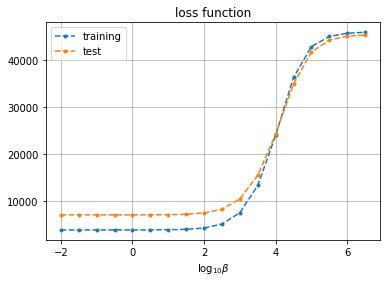

In [35]:
loss = [Results[log10_beta].loss for log10_beta in log10_betas]
loss_test = [Results[log10_beta].loss_test for log10_beta in log10_betas]

plt.title('loss function')
plt.plot(log10_betas, loss, '.--', label = 'training')
plt.plot(log10_betas, loss_test, '.--', label = 'test')
plt.xlabel(r'$\log_{10}\beta$')
plt.legend()
plt.grid()

In [26]:
infos['global']['names_ff_pars']

['sin alpha', 'cos alpha']

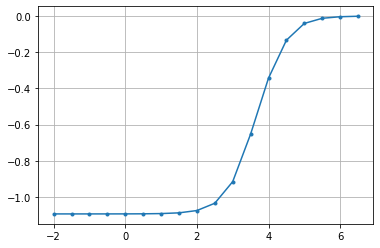

In [39]:
coeffs = [Results[log10_beta].pars[1] for log10_beta in log10_betas]

plt.plot(log10_betas, coeffs, '.-')
plt.grid()

In [36]:
chi2s = [np.sum(unwrap_dict(Results[log10_beta].chi2)) for log10_beta in log10_betas]
n_obs_train = data_train['global'].tot_n_experiments(data_train)

red_chi2s = np.array(chi2s)/n_obs_train

chi2s_test1 = [np.sum(unwrap_dict(Results[log10_beta].chi2_test)) for log10_beta in log10_betas] # .chi2_test
red_chi2s_test1 = np.array(chi2s_test1)/n_obs_train

chi2s_test2 = [np.sum(unwrap_dict(Results[log10_beta].chi2_new_obs)) for log10_beta in log10_betas] # .chi2_test
n_obs_test = len(unwrap_dict(test_obs))

red_chi2s_test2 = np.array(chi2s_test2)/n_obs_test

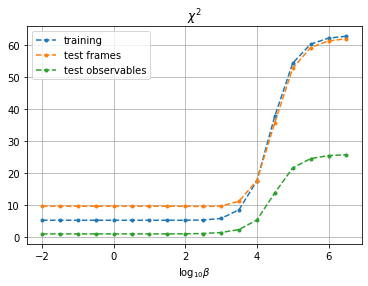

In [37]:
plt.plot(log10_betas, red_chi2s, '.--', label = 'training')
plt.plot(log10_betas, red_chi2s_test1, '.--', label = 'test frames')
plt.plot(log10_betas, red_chi2s_test2, '.--', label = 'test observables')

plt.legend()
plt.title('$\chi^2$')
plt.xlabel(r'$\log_{10}\beta$')
plt.grid()

What's happened at random_seed = 2 (without uNOEs)? With this choice of training/test set, the loss function in training is not (always) increasing with $\beta$, however the minimization has always success.

In [25]:
print([Results[log10_beta].mini.success for log10_beta in log10_betas])

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]


Since the loss function at low values of $\beta$ is higher than the one at $\log_{10}\beta = 0.5$ (and the optimal loss is always increasing with $\beta$), this means for such $\beta$ we ended up in another (local) minimum. So, let's use optimal coefficients found at  $\log_{10}\beta = 0.5$ as starting point for the minimization (**starting_pars**).

In [22]:
starting_pars = Results[0.5].pars

In [23]:
log10_betas = np.arange(-2, 7, 0.5)

Results = {}

for log10_beta in log10_betas:
    print(log10_beta)

    beta = 10**np.float64(log10_beta)
    Results[log10_beta] = minimizer(data_train, regularization = regularization, beta = beta, data_test = data_test, starting_pars = starting_pars)

    print(Results[log10_beta].loss)

    clear_output()

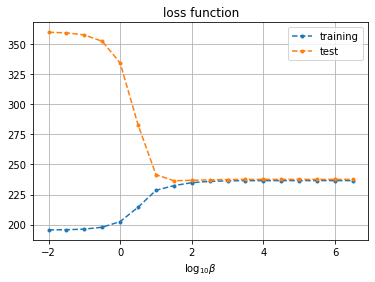

In [24]:
loss = [Results[log10_beta].loss for log10_beta in log10_betas]
loss_test = [Results[log10_beta].loss_test for log10_beta in log10_betas]

plt.title('loss function')
plt.plot(log10_betas, loss, '.--', label = 'training')
plt.plot(log10_betas, loss_test, '.--', label = 'test')
plt.xlabel(r'$\log_{10}\beta$')
plt.legend()
plt.grid()

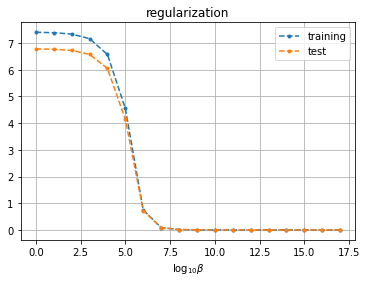

In [25]:
D_KL_train = [np.sum(unwrap_dict(Results[log10_beta].reg_ff)) for log10_beta in log10_betas]
D_KL_test = [np.sum(unwrap_dict(Results[log10_beta].reg_ff_test)) for log10_beta in log10_betas]

plt.title('regularization')
plt.plot(D_KL_train, '.--', label = 'training')
plt.plot(D_KL_test, '.--', label = 'test')
plt.xlabel(r'$\log_{10}\beta$')
plt.legend()
plt.grid()

In [26]:
chi2s = [np.sum(unwrap_dict(Results[log10_beta].chi2)) for log10_beta in log10_betas]
n_obs_train = data_train['global'].tot_n_experiments(data_train)

red_chi2s = np.array(chi2s)/n_obs_train

chi2s_test1 = [np.sum(unwrap_dict(Results[log10_beta].chi2_test)) for log10_beta in log10_betas] # .chi2_test
red_chi2s_test1 = np.array(chi2s_test1)/n_obs_train

chi2s_test2 = [np.sum(unwrap_dict(Results[log10_beta].chi2_new_obs)) for log10_beta in log10_betas] # .chi2_test
n_obs_test = len(unwrap_dict(test_obs))

red_chi2s_test2 = np.array(chi2s_test2)/n_obs_test

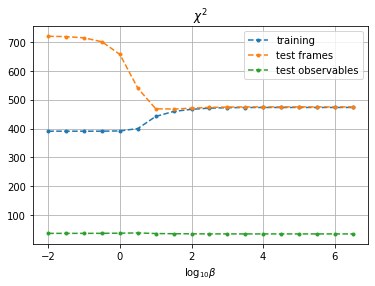

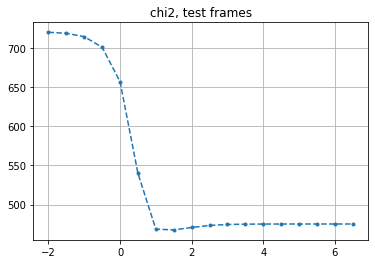

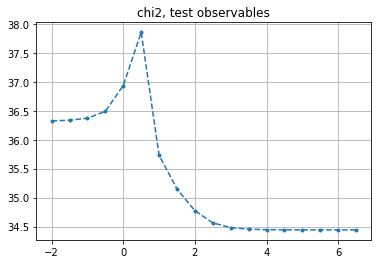

In [27]:
plt.plot(log10_betas, chi2s, '.--', label = 'training')
plt.plot(log10_betas, chi2s_test1, '.--', label = 'test frames')
plt.plot(log10_betas, chi2s_test2, '.--', label = 'test observables')

plt.legend()
plt.title('$\chi^2$')
plt.xlabel(r'$\log_{10}\beta$')
plt.grid()

plt.figure()
plt.plot(log10_betas, chi2s_test1, '.--', label = 'test frames')
plt.title('chi2, test frames')
plt.grid()

plt.figure()
plt.plot(log10_betas, chi2s_test2, '.--', label = 'test observables')
plt.title('chi2, test observables')
plt.grid()

### d. Determine optimal hyper parameter $\beta$ through cross validation (automatic optimization)

Let's take the same random_state used for the scan. Here **random_states** can be a list of values or an integer; if it is an integer, you will take values in np.arange(random_states).

In [28]:
starting_beta = 1

mini = hyper_minimizer(data, regularization = regularization, starting_beta = starting_beta, random_states = [2], starting_pars = starting_pars)

Input random_state employed both for test_obs and test_frames
log10 hyperpars:  [DeviceArray(0., dtype=float64)] ['beta']
tot chi2:  657.0989509863348
tot gradient:  [-152.45869821]
log10 hyperpars:  [0.] ['beta']
tot chi2:  657.0989509863348
tot gradient:  [-152.45869821]
log10 hyperpars:  [1.01] ['beta']
tot chi2:  468.3693258698372
tot gradient:  [-22.5461002]
log10 hyperpars:  [1.1852837] ['beta']
tot chi2:  467.07360566704546
tot gradient:  [-1.34951948]
log10 hyperpars:  [1.19644346] ['beta']
tot chi2:  467.0602418806326
tot gradient:  [-1.0524543]
log10 hyperpars:  [1.22209289] ['beta']
tot chi2:  467.0413456162542
tot gradient:  [-0.42517636]


In [29]:
mini

      fun: 467.0413456162542
 hess_inv: array([[0.03756671]])
      jac: array([-0.42517636])
  message: 'Optimization terminated successfully.'
     nfev: 5
      nit: 4
     njev: 5
   status: 0
  success: True
        x: array([1.22209289])

In [34]:
starting_beta = 10**mini.x

mini2 = hyper_minimizer(data, regularization = regularization, starting_beta = starting_beta, random_states = [2], which_set = 'test', starting_pars = starting_pars)


Input random_state employed both for test_obs and test_frames


/u/i/igilardo/3_alphabetagamma/Functions.py:2178: OptimizeWarning: Unknown solver options: maxfev
  hyper_mini = minimize(hyper_function, log10_hyperpars0, args = args, method = 'BFGS', jac = True, options = {'gtol': gtol, 'maxfev': 20})#, 'ftol': 0.1})


log10 hyperpars:  [1.22209289] ['beta']
New evaluation:
loss:  275.9155436501145
gradient:  [ 15.35127511  -9.04572861 -17.39103002  15.82186062] 

New evaluation:
loss:  271.2288368007547
gradient:  [ 21.55634479 -15.11850864  34.20302808 -18.6338733 ] 

New evaluation:
loss:  272.357448770612
gradient:  [-48.31790364 -15.3158465  -31.55294149 -12.06668938] 

New evaluation:
loss:  268.69454038601975
gradient:  [ -3.94195706 -15.14120574   9.81590609 -15.85437518] 

New evaluation:
loss:  263.73416077611796
gradient:  [ -4.41017571 -14.61961542   8.9840051  -12.96736957] 

New evaluation:
loss:  248.01464402792865
gradient:  [ -3.9952376  -11.95298115   9.40247393   1.81615909] 

New evaluation:
loss:  238.2293291226762
gradient:  [-13.22534213  19.0581175  -13.64305686   0.45961333] 

New evaluation:
loss:  235.62816325607469
gradient:  [-6.78958971 -7.20917815 -1.98527689 -3.62422861] 

New evaluation:
loss:  275.5164990990347
gradient:  [10.03510966 66.90537498 40.36704847 16.23575

In [35]:
mini2

      fun: 132.21272885005425
 hess_inv: array([[0.04261599]])
      jac: array([0.27195238])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 2
     njev: 4
   status: 0
  success: True
        x: array([1.15049021])

#### multiple seeds
in order to get more robust results and avoid local minima 

Let's use 2 random_states [0, 1]

In [36]:
starting_beta = 1

mini = hyper_minimizer(data, regularization = regularization, starting_beta = starting_beta, random_states = 2)

Input random_state employed both for test_obs and test_frames
Input random_state employed both for test_obs and test_frames
log10 hyperpars:  [0.] ['beta']
New evaluation:
loss:  232.03396939608317
gradient:  [-71.76903903  -5.50396973 -51.47297004 -14.96441254] 

New evaluation:
loss:  209.3237551897244
gradient:  [ 1.91964428 -0.2070328   7.12258622 -4.61135859] 

New evaluation:
loss:  754.3009782677531
gradient:  [100.18299117 -38.11978997   8.27176677  55.42594161] 

New evaluation:
loss:  208.56882815017454
gradient:  [ 1.89118245  0.90379216  7.67540293 -2.55457306] 

New evaluation:
loss:  207.06287927808435
gradient:  [ 2.38351279  0.41791025  8.34649019 -1.6563974 ] 

New evaluation:
loss:  207.134978140154
gradient:  [  2.76218824   7.17962407 -18.06578377   9.25915916] 

New evaluation:
loss:  204.56412161010527
gradient:  [2.56130963 1.60978088 4.60399415 2.2174964 ] 

New evaluation:
loss:  209.0164700744682
gradient:  [  3.32259559  10.61258435 -29.4412328   10.7129315 ]

In [37]:
mini

      fun: 887.3288621393083
 hess_inv: array([[0.02972008]])
      jac: array([-0.38020489])
  message: 'Optimization terminated successfully.'
     nfev: 8
      nit: 4
     njev: 8
   status: 0
  success: True
        x: array([0.4458335])

In [46]:
log10_betas = np.arange(-2, 7, 0.5)
random_states = np.arange(2)

Results = {}

for random_state in random_states:
    
    Results[random_state] = {}

    data_train, data_test, test_obs, test_frames = select_traintest(data, random_state = random_state)

    for log10_beta in log10_betas:

        print(random_state, log10_beta)

        beta = 10**np.float64(log10_beta)
        Results[random_state][log10_beta] = minimizer(data_train, regularization = regularization, beta = beta, data_test = data_test)

        clear_output()

In [47]:
chi2s = []
chi2s_test1 = []
chi2s_test2 = []

for random_state in random_states:

    chi2s.append([np.sum(unwrap_dict(Results[random_state][log10_beta].chi2)) for log10_beta in log10_betas])
    chi2s_test1.append([np.sum(unwrap_dict(Results[random_state][log10_beta].chi2_test)) for log10_beta in log10_betas]) # .chi2_test
    chi2s_test2.append([np.sum(unwrap_dict(Results[random_state][log10_beta].chi2_new_obs)) for log10_beta in log10_betas]) # .chi2_test


In [50]:
np.sum(chi2s, axis = 0)

array([809.5228564 , 809.52341081, 809.52885058, 809.58025051,
       810.03572158, 814.556873  , 826.18925646, 846.9433294 ,
       875.85522829, 894.73193725, 902.54606228, 905.24866257,
       906.12830864, 906.40904183, 906.49807601, 906.52625701,
       906.53517122, 906.5379904 ])

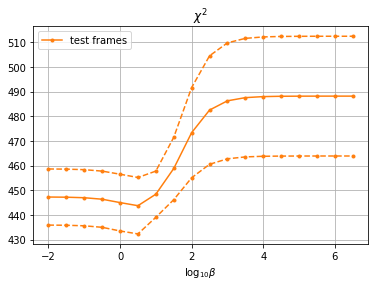

In [56]:
# plt.plot(log10_betas, np.mean(chi2s, axis = 0), '.-', label = 'training', color = 'tab:blue')
plt.plot(log10_betas, np.mean(chi2s_test1, axis = 0), '.-', label = 'test frames', color = 'tab:orange')
# plt.plot(log10_betas, np.mean(chi2s_test2, axis = 0), '.-', label = 'test observables', color = 'tab:green')

for i in range(len(chi2s)):
    # plt.plot(log10_betas, chi2s[i], '.--', color = 'tab:blue')
    plt.plot(log10_betas, chi2s_test1[i], '.--', color = 'tab:orange')
    # plt.plot(log10_betas, chi2s_test2[i], '.--', color = 'tab:green')

plt.legend()
plt.title('$\chi^2$')
plt.xlabel(r'$\log_{10}\beta$')
plt.grid()

## 2b. Force-field refinement - alchemical calculations

Reproduce results from *Piomponi, Valerio, et al. "Molecular simulations matching denaturation experiments for N6-methyladenosine." ACS Central Science 8.8 (2022): 1218-1228.* https://pubs.acs.org/doi/full/10.1021/acscentsci.2c00565

### a. Load data

For alchemical calculations, we have both system_names (names of each molecular system) and cycle_names (names of the thermodynamic cycles); each cycle is composed by 4 systems; system_names with corresponding thermodynamic cycle must be defined as 'cycle_name' + '_' + s for s in ['AS','AD','MS','MD'] (A for adenosine, M for methylated; S for single, D for double strand). The experimental DG is between (AS, AD) and (MS, MD), the simulated one is between (AS, MS) and (AD, MD).

In [5]:
infos = {}

infos['global'] = {}
infos['global']['temperature'] = 2.476
infos['global']['path_directory'] = '../../DATA_alchemical'

infos['global']['cycle_names'] = ['A1','A2','A3','A4','A5']#,'B1','B2','B3','B4','B5']

system_names = []
for name in infos['global']['cycle_names']:
    for string in ['AS','AD','MS','MD']:
        system_names.append(name+'_'+string)

infos['global']['system_names'] = system_names

# force-field correction terms

n_charges = 5

infos['global']['names_ff_pars'] = ['DQ %i' % (i+1) for i in range(n_charges)] + ['cos eta']

columns = []
for i in range(n_charges):
    columns.append('DQ %i' % (i+1))
    columns.append('DQ %i%i' % (i+1,i+1))
for i in range(n_charges):
    for j in range(i+1,n_charges):
        columns.append('DQ %i%i' % (i+1,j+1))
columns.append('cos eta')

# only methylated (M) systems have a force-field correction

for name in system_names: infos[name] = {}

for name in infos['global']['cycle_names']:
    for s in ['D','S']:
        infos[name + '_M' + s]['ff_terms'] = columns

define the force-field correction:

\begin{equation}
\Delta U(x) = \sum_{i=1}^5 K_i(x) \Delta Q_i + \sum_{i=1}^5 \sum_{j=i}^5 K_{ij}(x) \Delta Q_i \Delta Q_j - V_\eta \cos\eta_6(x).
\end{equation}

- use jax.numpy rather than numpy in order to do automatic differentiation
- phi is: ['DQ %i' for i in range(n_charges)] + ['cos eta']
- phi_vector is

['DQ 1', 'DQ 11', 'DQ 2', 'DQ 22', 'DQ 3', 'DQ 33', 'DQ 4', 'DQ 44', 'DQ 5', 'DQ 55', 'DQ 12', 'DQ 13', 'DQ 14', 'DQ 15', 'DQ 23', 'DQ 24', 'DQ 25', 'DQ 34', 'DQ 35', 'DQ 45', 'cos eta']

where 2 numbers (such as 'DQ 11' or 'DQ 23') mean the product 'DQ 1 * DQ 1' or 'DQ 2 * DQ 3'.

Legend: (Q1: N6; Q2: H61; Q3: N1; Q4: C10; Q5: H101/2/3)

In [6]:
names_charges = ['N6', 'H61', 'N1', 'C10', 'H101/2/3']

In [7]:
def ff_correction(phi, ff_terms):

    n_charges = 5

    phi_vector = []
    for i in range(n_charges):
        phi_vector.extend([phi[i], phi[i]**2])
    for i in range(n_charges):
        for j in range(i+1,n_charges):
            phi_vector.append(phi[i]*phi[j])
    phi_vector.append(-phi[-1])
    phi_vector = jnp.array(phi_vector)

    correction = jnp.matmul(ff_terms, phi_vector)

    return correction

In [8]:
for k in system_names:
    if k[-2] == 'M': 
        infos[k]['ff_correction'] = ff_correction

In [9]:
data = load_data(infos)

loading data from directory...
loading  A1_AS
loading  A1_AD
loading  A1_MS
loading  A1_MD
loading  A2_AS
loading  A2_AD
loading  A2_MS
loading  A2_MD
loading  A3_AS
loading  A3_AD
loading  A3_MS
loading  A3_MD
loading  A4_AS
loading  A4_AD
loading  A4_MS
loading  A4_MD
loading  A5_AS
loading  A5_AD
loading  A5_MS
loading  A5_MD
done


In order to avoid numerical issues, put to zero the force-field correction terms corresponding to zero original weights; you could also this in a different way, by selecting only frames with non-zero weights, but then you would have to take this into account when computing the relative entropy or the Kish sample size.

In [10]:
for s in data['global'].system_names:
    # BE CAREFUL!!!
    # if you do this, then when you compute the relative entropy or Kish size,
    # you have to take into account how many zero frames there was

    # wh = np.argwhere(data.weights[s]!=0).flatten()

    # data.weights[s] = data.weights[s][wh]
    # if s in data.f.keys():
    #     data.f[s] = data.f[s].iloc[wh]

    # otherwise, you can put to zero the corresponding force-field correction terms

    if hasattr(data[s], 'f'):
        wh = np.argwhere(data[s].weights == 0).flatten()
        data[s].f[wh] = 0

Valerio put uncertainties = 1

In [11]:
for s in data['global'].cycle_names:
    data[s].gexp_DDG[1] = 1

### b. Minimize the loss function and analyse the results - scan over $\beta$

In [36]:
from joblib import Parallel, delayed

#### L2 regularization

Define regularization. Rather than 'plain l2', we now have a constraint due to the requirement $\sum_{i=0}^5 \Delta Q_i + 2\Delta Q_4 = 0$ (total charge constant, with 3 $Q_4$ charges), so we have defined 'constraint 1' as regularization in Functions.py

\begin{equation}
\sum_{i=0}^4 \Delta Q_i^2 + \Delta Q_5^2 = \sum_{i=0}^4 \Delta Q_i^2 + \Bigl(\sum_{i=0}^4 \Delta Q_i + 2 \Delta Q_4\Bigr)^2.
\end{equation}

No regularization is added on $V_\eta$ parameter.

In [37]:
regularization = {'force_field_reg': 'constraint 2'}

It can also be defined by the user

In [38]:
def my_ff_reg(pars):
    lossf_reg = jnp.sum(pars[:-1]**2) + (np.sum(pars[:-1]) + 2*pars[4])**2  # + pars[-1]**2
    return lossf_reg

In [39]:
regularization = {'force_field_reg': my_ff_reg}

In [40]:
betas = np.array([0.1, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 10000, 100000])

let's look firstly at original $\chi^2$

In [18]:
res = minimizer(data, regularization=regularization, beta=np.inf)

all the hyperparameters are infinite


In [20]:
res.chi2

{'A1': 21.06397979742576,
 'A2': 0.368626108813756,
 'A3': 12.38209101979724,
 'A4': 0.02181011054578029,
 'A5': 0.6429245282261995}

without parallelization

with parallelization (faster)

In [41]:
Results_l2 = Parallel(n_jobs=3, verbose=1)(delayed(minimizer)(
        data, regularization=regularization, beta=beta) for beta in betas)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  14 out of  14 | elapsed:  9.6min finished


around 5 min with parallelization, rather than 28 min

In [42]:
vars(Results_l2[0]).keys()

dict_keys(['loss', 'pars', 'mini', 'intermediates', 'time', 'reg_ff', 'av_g', 'chi2', 'weights_new', 'logZ_new'])

plot both the correction coefficients (charges and $V_\eta$) and the deviation from original ensemble (which can be measured by the Kish size, the relative entropy or the employed L2 regularization)

save figures and results in folders

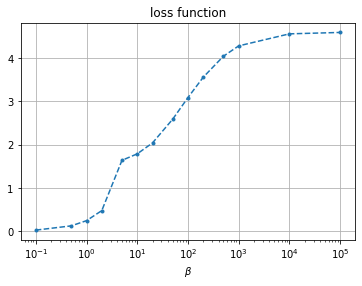

In [43]:
loss = [Results_l2[i].loss for i in range(len(Results_l2))]

plt.plot(betas, loss, '.--')
plt.xscale('log')
plt.title('loss function')
plt.xlabel(r'$\beta$')
plt.grid()
plt.show()

# plt.savefig('../../Figures/alchemical_L2_loss.png')

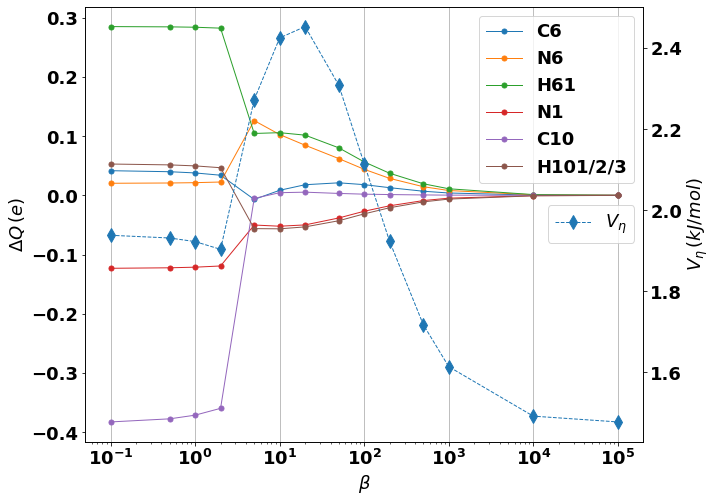

In [44]:
font = {'weight' : 'bold', 'size' : 18}

matplotlib.rc('font', **font)
matplotlib.rcParams['lines.linewidth'] = 1
matplotlib.rcParams['lines.markersize'] = 10

fig, ax1 = plt.subplots(figsize=(10, 8))
ax2 = ax1.twinx()

# due to the constraint: total charge = 0
C6_charges = [(-np.sum(Results_l2[i].pars[:-1]) - 2*Results_l2[i].pars[-2]) for i in range(len(Results_l2))]
ax1.plot(betas, C6_charges, '.-', label='C6')

for j in range(len(names_charges)):
    ax1.plot(betas, [Results_l2[i].pars[j] for i in range(len(Results_l2))], '.-', label=names_charges[j])

ax2.plot(betas, [Results_l2[i].pars[-1] for i in range(len(Results_l2))], 'd--', label='$V_\eta$')

ax1.set_xscale('log')
ax1.set_xlabel(r'$\beta$')
ax1.grid(axis='x')

ax1.set_ylabel('$\Delta Q \, (e)$')
ax2.set_ylabel('$V_\eta \, (kJ/mol)$')

# ax1.set_ylim([-0.45, 0.35])
# ax2.set_ylim([1.4, 2.5])

ax1.legend()#loc='upper right')
ax2.legend(loc='center right')

# plt.title('$\Delta Q$ parameters')
# plt.xlabel('$\beta$')
# plt.legend()
# plt.grid()
plt.show()

# plt.savefig('../../Figures/alchemical_L2_parameters.png')

In [45]:
vec = np.array([Results_l2[i].pars for i in range(len(Results_l2))])

df = pandas.DataFrame(vec[:,:-1], columns=[n + ' (e)' for n in names_charges])
df['C6 (e)'] = C6_charges
df[r'$V_\eta (kJ/mol)$'] = vec[:, -1]
df.index = betas

# df.to_csv('../../Results/alchemical_calculations/coefficients_L2charges')

Kish ratio: the ratio between Kish sizes of ensembles with original and optimized force field, respectively (for methylated systems) 


In [127]:
names = []

for name_sys in data['global'].system_names:
    if name_sys[-2] == 'M':
        names.append(name_sys)

kish_ratios = {}

for name_sys in names:
    kish_ratios[name_sys] = []
    for i in range(len(Results_l2)):
        ratio = np.sum(data[name_sys].weights**2)/np.sum(Results_l2[i].weights_new[name_sys]**2)
        kish_ratios[name_sys].append(ratio)

In [129]:
kish_ratios['average'] = []

for i in range(len(Results_l2)):
    kish_ratios['average'].append(np.mean([kish_ratios[name_sys][i] for name_sys in names]))

In [151]:
kish_sizes = {}

for name_sys in names:
    kish_sizes[name_sys] = []
    for i in range(len(Results_l2)):
        kish_sizes[name_sys].append(np.sum(Results_l2[i].weights_new[name_sys]**2))

In [152]:
kish_sizes['average'] = []

for i in range(len(Results_l2)):
    kish_sizes['average'].append(np.mean([kish_sizes[name_sys][i] for name_sys in names]))

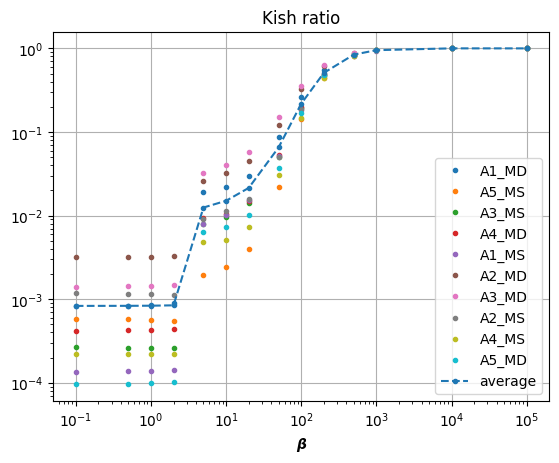

In [130]:
matplotlib.rcdefaults()

for name in set(kish_ratios.keys())-set(['average']):
    plt.plot(betas, kish_ratios[name], '.', label=name)

plt.plot(betas, kish_ratios['average'], '.--', label='average')

plt.xscale('log')
plt.title('Kish ratio')
plt.xlabel(r'$\beta$')
plt.legend()
plt.yscale('log')
plt.grid()
plt.show()


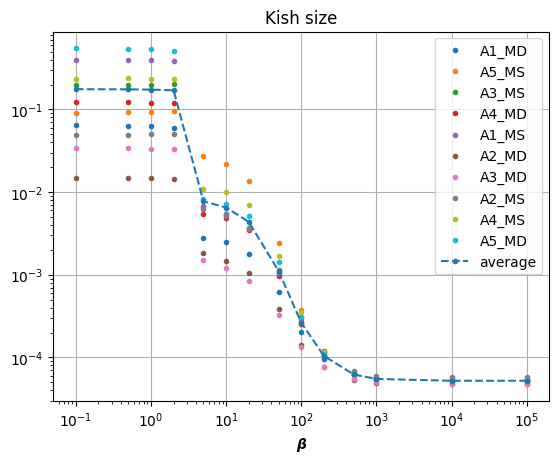

In [154]:
matplotlib.rcdefaults()

for name in set(kish_sizes.keys())-set(['average']):
    plt.plot(betas, kish_sizes[name], '.', label=name)

plt.plot(betas, kish_sizes['average'], '.--', label='average')

plt.xscale('log')
plt.title('Kish size')
plt.xlabel(r'$\beta$')
plt.legend()
plt.yscale('log')
plt.grid()
plt.show()

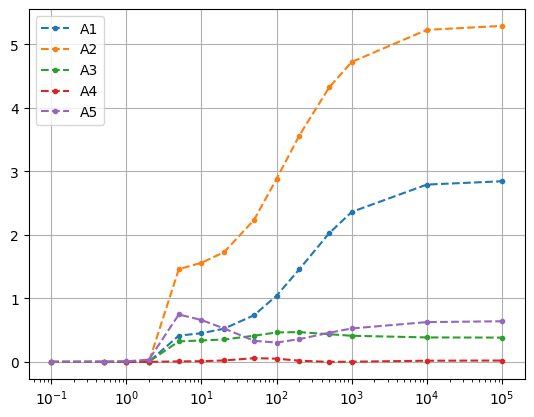

In [131]:
for cycle_name in data['global'].cycle_names:
    chi2s = [Results_l2[i].chi2[cycle_name] for i in range(len(Results_l2))]
    plt.plot(betas, chi2s, '.--', label=cycle_name)

plt.xscale('log')
plt.legend()
plt.grid()

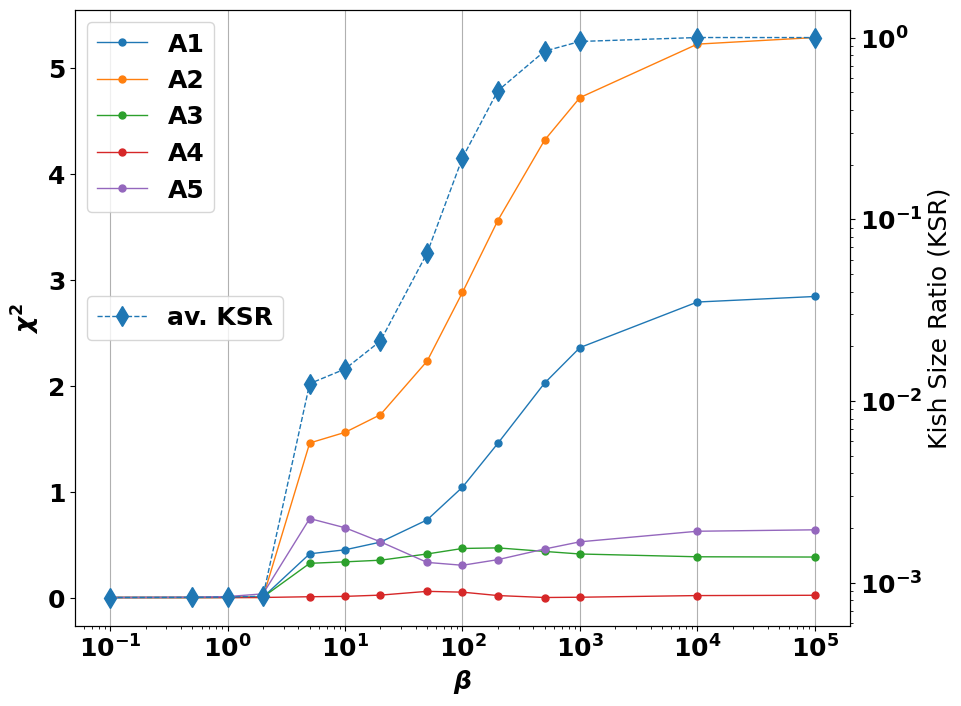

In [137]:
font = {'weight' : 'bold', 'size' : 18}

matplotlib.rc('font', **font)
matplotlib.rcParams['lines.linewidth'] = 1
matplotlib.rcParams['lines.markersize'] = 10

fig, ax1 = plt.subplots(figsize=(10, 8))
ax2 = ax1.twinx()

chi2s = {}
for cycle_name in data['global'].cycle_names:
    chi2s[cycle_name] = [Results_l2[i].chi2[cycle_name] for i in range(len(Results_l2))]
    ax1.plot(betas, chi2s[cycle_name], '.-', label=cycle_name)

ax2.plot(betas, kish_ratios['average'], 'd--', label='av. KSR')

ax1.set_xscale('log')
ax1.set_xlabel(r'$\beta$')
ax1.grid(axis='x')

ax1.set_ylabel('$\chi^2$')
ax2.set_ylabel('Kish Size Ratio (KSR)')
ax2.set_yscale('log')

# ax1.set_ylim('low': 0)#[-0.45, 0.35])
# ax2.set_ylim([1.4, 2.5])

ax1.legend()#loc='upper right')
ax2.legend(loc='center left')

# plt.title('$\Delta Q$ parameters')
# plt.xlabel('$\beta$')
# plt.legend()
# plt.grid()
plt.show()

# plt.savefig('../../Figures/alchemical_L2_Kish_chi2.png')

In [138]:
arr = np.vstack((np.array(loss), kish_ratios['average'], [chi2s[cycle_name] for cycle_name in data['global'].cycle_names])).T
df = pandas.DataFrame(arr)
df.columns = ['loss', 'kish ratio'] + ['chi2s ' + name for name in data['global'].cycle_names]
df.index = betas

# df.to_csv('../../Results/alchemical_calculations/values_L2charges')

#### relative entropy regularization

In [16]:
regularization = {'force_field_reg': 'KL divergence'}

In [17]:
betas = [1e-3, 5e-3, 2e-2, 5e-2, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1e3, 5e3, 1e4, 5e4, 1e5, 5e5, 1e6, 5e6]

In [18]:
Results = {}

for beta in betas:
    print('beta: ', beta)
    
    Results[beta] = minimizer(data, regularization=regularization, beta=beta)

    clear_output()

In [19]:
print([Results[beta].mini.success for beta in betas])

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]


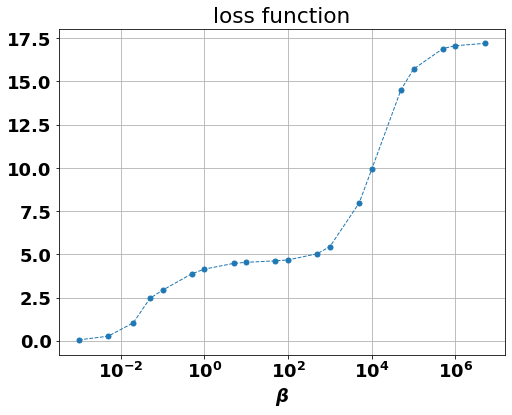

In [20]:
loss = [Results[beta].loss for beta in betas]

font = {'weight' : 'bold', 'size' : 18}

matplotlib.rc('font', **font)
matplotlib.rcParams['lines.linewidth'] = 1
matplotlib.rcParams['lines.markersize'] = 10

plt.figure(figsize=(8, 6))

plt.plot(betas, loss, '.--')
plt.xscale('log')
plt.title('loss function')
plt.xlabel(r'$\beta$')
plt.grid()
# plt.show()

# plt.savefig('../../Figures/alchemical_DKL_loss.png')

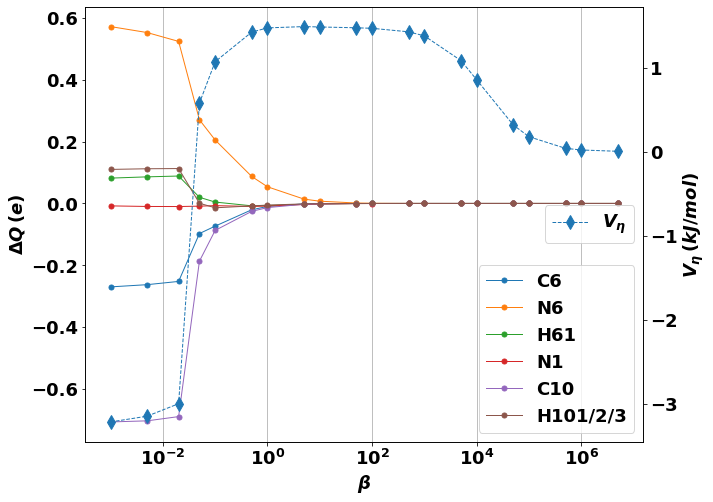

In [73]:
font = {'weight' : 'bold', 'size' : 18}

matplotlib.rc('font', **font)
matplotlib.rcParams['lines.linewidth'] = 1
matplotlib.rcParams['lines.markersize'] = 10

fig, ax1 = plt.subplots(figsize=(10, 8))
ax2 = ax1.twinx()

# due to the constraint: total charge = 0
C6_charges = [(-np.sum(Results[beta].pars[:-1]) - 2*Results[beta].pars[-2]) for beta in betas]
ax1.plot(betas, C6_charges, '.-', label='C6')

for j in range(len(names_charges)):
    ax1.plot(betas, [Results[beta].pars[j] for beta in betas], '.-', label=names_charges[j])

ax2.plot(betas, [Results[beta].pars[-1] for beta in betas], 'd--', label='$V_\eta$')

ax1.set_xscale('log')
# ax1.set_yscale('symlog')
ax1.set_xlabel(r'$\beta$')
ax1.grid(axis='x')

ax1.set_ylabel('$\Delta Q \, (e)$')
ax2.set_ylabel('$V_\eta \, (kJ/mol)$')

# ax1.set_ylim([-0.45, 0.35])
# ax2.set_ylim([1.4, 2.5])

ax1.legend(loc='lower right')
ax2.legend(loc='center right')

# plt.title('$\Delta Q$ parameters')
# plt.xlabel('$\beta$')
# plt.legend()
# plt.grid()
# plt.show()

# plt.savefig('../../Figures/alchemical_DKL_parameters.png')

In [88]:
names = []

for name_sys in data['global'].system_names:
    if name_sys[-2] == 'M':
        names.append(name_sys)

kish_ratios = {}

for name_sys in names:
    kish_ratios[name_sys] = []
    for beta in betas:
        ratio = np.sum(data[name_sys].weights**2)/np.sum(Results[beta].weights_new[name_sys]**2)
        kish_ratios[name_sys].append(ratio)

In [89]:
kish_ratios['average'] = []

for i in range(len(Results)):
    kish_ratios['average'].append(np.mean([kish_ratios[name_sys][i] for name_sys in names]))

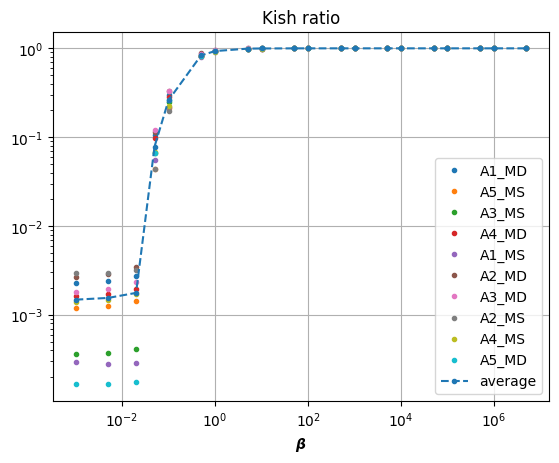

In [90]:
matplotlib.rcdefaults()

for name in set(kish_ratios.keys())-set(['average']):
    plt.plot(betas, kish_ratios[name], '.', label=name)

plt.plot(betas, kish_ratios['average'], '.--', label='average')

plt.xscale('log')
plt.title('Kish ratio')
plt.xlabel(r'$\beta$')
plt.legend()
plt.yscale('log')
plt.grid()
plt.show()


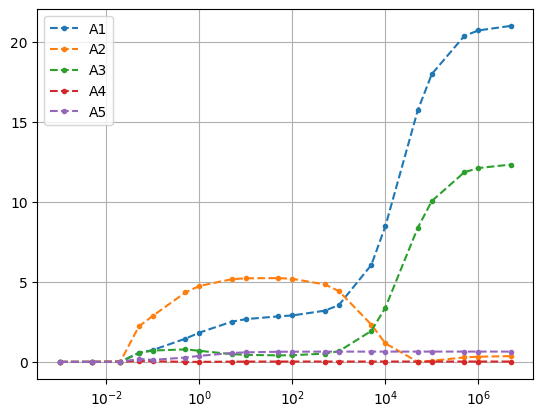

In [92]:
chi2s = {}

for cycle_name in data['global'].cycle_names:
    chi2s[cycle_name] = [Results[beta].chi2[cycle_name] for beta in betas]
    plt.plot(betas, chi2s[cycle_name], '.--', label=cycle_name)

plt.xscale('log')
plt.legend()
plt.grid()

In [108]:
arr = np.vstack((np.array(loss), kish_ratios['average'], [chi2s[cycle_name] for cycle_name in data['global'].cycle_names])).T
df = pandas.DataFrame(arr)
df.columns = ['loss', 'kish ratio'] + ['chi2s ' + name for name in data['global'].cycle_names]
df.index = betas

# df.to_csv('../../Results/alchemical_calculations/values_DKL')

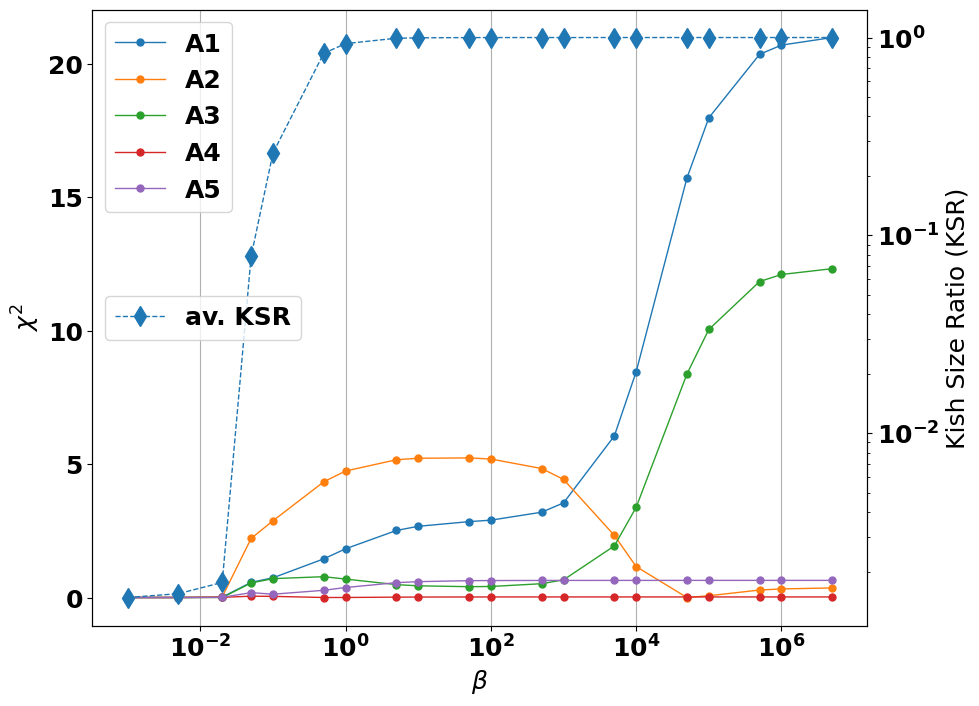

In [66]:
font = {'weight' : 'bold', 'size' : 18}

matplotlib.rc('font', **font)
matplotlib.rcParams['lines.linewidth'] = 1
matplotlib.rcParams['lines.markersize'] = 10

fig, ax1 = plt.subplots(figsize=(10, 8))
ax2 = ax1.twinx()

for cycle_name in data['global'].cycle_names:
    chi2s = [Results[beta].chi2[cycle_name] for beta in betas]
    ax1.plot(betas, chi2s, '.-', label=cycle_name)

ax2.plot(betas, kish_ratios['average'], 'd--', label='av. KSR')

ax1.set_xscale('log')
ax1.set_xlabel(r'$\beta$')
ax1.grid(axis='x')

ax1.set_ylabel('$\chi^2$')
ax2.set_ylabel('Kish Size Ratio (KSR)')
ax2.set_yscale('log')

# ax1.set_ylim('low': 0)#[-0.45, 0.35])
# ax2.set_ylim([1.4, 2.5])

ax1.legend()#loc='upper right')
ax2.legend(loc='center left')

# plt.title('$\Delta Q$ parameters')
# plt.xlabel('$\beta$')
# plt.legend()
# plt.grid()
# plt.show()

# plt.savefig('../../Figures/alchemical_DKL_Kish_chi2.png')

### c. Analyse saved data

,loss,kish ratio,chi2s A1,chi2s A2,chi2s A3,chi2s A4,chi2s A5,chi2 tot,D_KL tot,Kish size tot,...,D_KL A1_MS,D_KL A1_MD,D_KL A2_MS,D_KL A2_MD,D_KL A3_MS,D_KL A3_MD,D_KL A4_MS,D_KL A4_MD,D_KL A5_MS,D_KL A5_MD
0.1,0.024849,0.000830,0.000007,0.000002,0.000016,0.000002,0.000096,0.000122,65.342801,43484.234352,...,8.401618,6.133784,5.702919,4.526971,6.980991,5.023940,7.034803,6.998688,6.501791,8.037295
0.5,0.123052,0.000832,0.000169,0.000035,0.000356,0.000037,0.002336,0.002934,65.253200,43196.211771,...,8.388428,6.120363,5.704947,4.517528,6.981917,5.009703,7.025713,6.987807,6.503965,8.012829
1.0,0.243229,0.000835,0.000682,0.000089,0.001258,0.000144,0.009094,0.011267,65.125252,42797.638861,...,8.369651,6.101385,5.705433,4.504585,6.980255,4.990472,7.013052,6.973470,6.505063,7.981886
2.0,0.475590,0.000844,0.002764,0.000110,0.003969,0.000527,0.034657,0.042026,64.820969,41886.205641,...,8.325227,6.057145,5.700049,4.475114,6.968856,4.947587,6.983877,6.942363,6.502305,7.918446
5.0,1.636895,0.012473,0.412880,1.458890,0.322818,0.007464,0.745586,2.947638,28.905188,1443.166477,...,3.079575,2.575171,3.004829,2.077610,3.058544,1.918672,3.309681,2.949620,3.743368,3.188117
10.0,1.785725,0.015019,0.450525,1.559363,0.336794,0.010816,0.658568,3.016066,27.549793,1206.027650,...,2.927824,2.454876,2.857423,1.960272,2.909567,1.812578,3.190384,2.836296,3.544965,3.055610
20.0,2.038826,0.021401,0.522923,1.726002,0.352271,0.022686,0.526123,3.150005,24.576385,811.588512,...,2.620284,2.187589,2.561175,1.739691,2.598391,1.614839,2.866412,2.548341,3.105510,2.734153
50.0,2.586481,0.065285,0.733116,2.232175,0.411231,0.058318,0.331543,3.766383,15.752528,210.612955,...,1.713772,1.400959,1.671389,1.119442,1.681831,1.059370,1.841092,1.657364,1.877426,1.729884
100.0,3.086234,0.217886,1.041947,2.880699,0.463120,0.050621,0.304509,4.740896,8.078823,51.233427,...,0.893211,0.719048,0.863624,0.579610,0.876099,0.562703,0.933400,0.860864,0.924921,0.865343
200.0,3.555848,0.509627,1.455247,3.559243,0.468680,0.018664,0.357524,5.859358,3.515177,20.454070,...,0.390136,0.313451,0.375504,0.254835,0.387356,0.252508,0.398531,0.376053,0.397182,0.369619


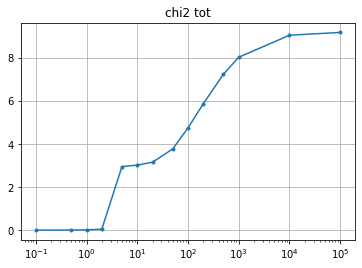

In [12]:
df = pandas.read_csv('../../Results/alchemical_calculations/values_L2charges', index_col=0)

my_list = [s for s in df.columns if s.startswith('chi2s')]
df['chi2 tot'] = np.sum(np.array(df[my_list]), axis=1)

plt.plot(df['chi2 tot'], '.-')
plt.xscale('log')
plt.title('chi2 tot')
plt.grid()

df

,loss,kish ratio,chi2s A1,chi2s A2,chi2s A3,chi2s A4,chi2s A5,chi2 tot,D_KL tot,Kish size tot,...,Kish size A3_MD,D_KL A3_MD,Kish size A4_MS,D_KL A4_MS,Kish size A4_MD,D_KL A4_MD,Kish size A5_MS,D_KL A5_MS,Kish size A5_MD,D_KL A5_MD
0.001,0.053460,0.001481,0.000010,0.000071,0.000027,0.000150,0.000007,0.000265,5.332776e+01,16653.141175,...,531.369337,4.471916e+00,722.771000,5.117847e+00,800.053626,4.974837e+00,859.270952,5.516009e+00,5073.489942,7.015897e+00
0.005,0.265267,0.001550,0.000495,0.001470,0.000260,0.001639,0.000327,0.004191,5.263417e+01,16442.594443,...,482.609990,4.360445e+00,701.646233,5.065767e+00,786.542877,4.940206e+00,776.219429,5.423201e+00,5013.281320,6.971740e+00
0.020,1.040350,0.001765,0.013672,0.021460,0.000881,0.006965,0.008658,0.051636,5.072658e+01,15016.306580,...,402.089562,4.132374e+00,623.499914,4.896359e+00,695.852599,4.791316e+00,665.036149,5.226694e+00,4665.106513,6.779752e+00
0.050,2.455869,0.078484,0.568532,2.215856,0.545488,0.049747,0.182933,3.562556,1.349182e+01,151.160766,...,7.840894,1.053671e+00,14.566398,1.474209e+00,10.868050,1.316906e+00,22.183385,1.519911e+00,15.221658,1.377257e+00
0.100,2.926841,0.260983,0.738401,2.877295,0.708036,0.043712,0.124069,4.491513,6.810844e+00,40.479242,...,2.983465,5.429204e-01,4.365376,7.443178e-01,3.657658,6.753503e-01,4.782424,7.441470e-01,3.902621,6.925815e-01
0.500,3.875654,0.832352,1.449649,4.337262,0.781220,0.000692,0.270678,6.839501,9.118066e-01,12.004403,...,1.150777,7.004492e-02,1.219877,9.874849e-02,1.203594,9.332668e-02,1.222890,1.001281e-01,1.211498,9.626269e-02
1.000,4.146271,0.931631,1.827697,4.743034,0.691536,0.001633,0.375458,7.639358,3.265922e-01,10.673833,...,1.048965,2.390261e-02,1.073979,3.568828e-02,1.069804,3.393732e-02,1.075175,3.620013e-02,1.072096,3.496553e-02
5.000,4.478843,0.991879,2.513192,5.164553,0.483640,0.014356,0.557038,8.732778,2.249068e-02,10.045003,...,1.003135,1.563737e-03,1.005000,2.500281e-03,1.004746,2.374086e-03,1.005020,2.506004e-03,1.004833,2.417386e-03
10.000,4.540060,0.996526,2.670008,5.220941,0.438567,0.017641,0.595508,8.942664,6.872777e-03,10.013735,...,1.001038,5.167292e-04,1.001517,7.600161e-04,1.001435,7.190401e-04,1.001516,7.588536e-04,1.001446,7.245994e-04
50.000,4.626489,0.999386,2.844450,5.232826,0.406299,0.020744,0.631327,9.135647,1.173302e-03,10.002340,...,1.000279,1.377536e-04,1.000236,1.189244e-04,1.000220,1.110736e-04,1.000241,1.216296e-04,1.000215,1.085569e-04


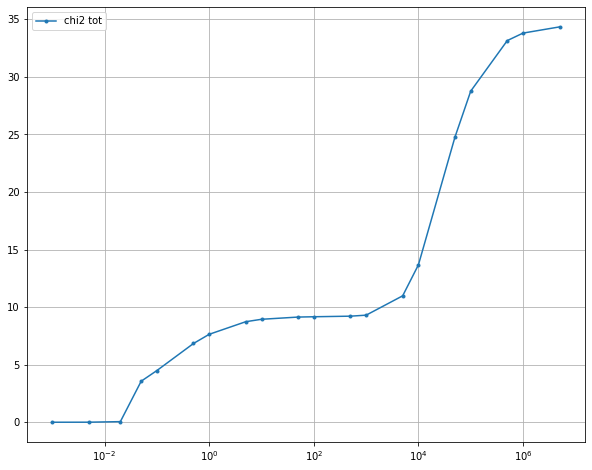

In [13]:
df2 = pandas.read_csv('../../Results/alchemical_calculations/values_DKL', index_col=0)

my_list = [s for s in df2.columns if s.startswith('chi2s')]
df2['chi2 tot'] = np.sum(np.array(df2[my_list]), axis=1)

plt.figure(figsize=(10, 8))
# plt.plot(df['chi2 tot'], '.-', label='L2 reg. on charges')
plt.plot(df2['chi2 tot'], '.-', label='chi2 tot')
plt.xscale('log')
plt.legend()
plt.grid()

df2

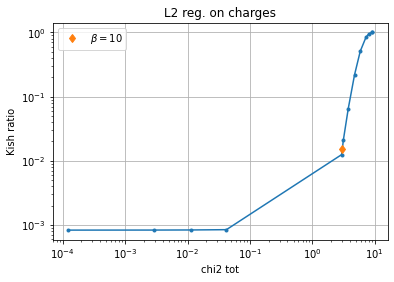

In [14]:
plt.plot(df['chi2 tot'], df['kish ratio'], '.-')
plt.plot(df['chi2 tot'][10], df['kish ratio'][10], 'd', label=r'$\beta=10$')
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.title('L2 reg. on charges')
plt.xlabel('chi2 tot')
plt.ylabel('Kish ratio')
plt.legend()
# plt.savefig('../../Figures/alchemical_L2charges_kish_vs_chi2.png')

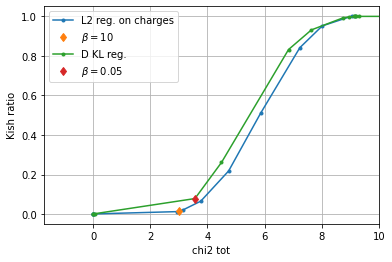

In [15]:
plt.plot(df['chi2 tot'], df['kish ratio'], '.-', label='L2 reg. on charges')
plt.plot(df['chi2 tot'][10], df['kish ratio'][10], 'd', label=r'$\beta=10$')

plt.plot(df2['chi2 tot'], df2['kish ratio'], '.-', label='D KL reg.')
plt.plot(df2['chi2 tot'][0.05], df2['kish ratio'][0.05], 'd', label=r'$\beta=0.05$')

# plt.xscale('log')
# plt.yscale('log')
plt.grid()
# plt.title('relative entropy reg.')
plt.xlabel('chi2 tot')
plt.ylabel('Kish ratio')
plt.xlim(right=10)
plt.legend()
# plt.savefig('../../Figures/alchemical_DKL_kish_vs_chi2.png')
# plt.savefig('../../Figures/alchemical_kish_vs_chi2_linear_upxlimit.png')

#### compute Kish sizes and relative entropies
firstly, compute new weights from optimal coefficients

In [16]:
from MDRefine import compute_new_weights, compute_D_KL

In [17]:
coeffs_L2_df = pandas.read_csv('../../Results/alchemical_calculations/coefficients_L2charges', index_col=0)
coeffs_DKL_df = pandas.read_csv('../../Results/alchemical_calculations/coefficients_DKL', index_col=0)

betas = coeffs_L2_df.index

weights_L2 = {}
kish_size_L2 = {}
kish_ratio_L2 = {}
rel_entropy_L2 = {}

for i, beta in enumerate(betas):
    coeffs_L2 = list(coeffs_L2_df.iloc[i, :5]) + [coeffs_L2_df.iloc[i, 6]]

    weights_L2[beta] = {}
    kish_size_L2[beta] = {}
    kish_ratio_L2[beta] = {}
    rel_entropy_L2[beta] = {}

    for sys_name in data['global'].system_names:
        if hasattr(data[sys_name], 'f'):
            wh = np.argwhere(data[sys_name].weights != 0)
            w0 = data[sys_name].weights[wh]
            weights_L2[beta][sys_name] = compute_new_weights(data[sys_name].weights, ff_correction(coeffs_L2, data[sys_name].f)/data[sys_name].temperature)[0][wh]

            kish_size_L2[beta][sys_name] = np.sum(weights_L2[beta][sys_name]**2/w0)
            kish_ratio_L2[beta][sys_name] = np.sum(w0**2)/np.sum(weights_L2[beta][sys_name]**2)

            wh = np.argwhere(weights_L2[beta][sys_name] != 0)
            rel_entropy_L2[beta][sys_name] = np.sum(weights_L2[beta][sys_name][wh]*np.log(weights_L2[beta][sys_name][wh]/w0[wh]))

betas = coeffs_DKL_df.index

weights_DKL = {}
kish_size_DKL = {}
rel_entropy_DKL = {}
kish_ratio_DKL = {}

for i, beta in enumerate(betas):
    coeffs_DKL = list(coeffs_DKL_df.iloc[i, :5]) + [coeffs_DKL_df.iloc[i, 6]]
    
    weights_DKL[beta] = {}
    kish_size_DKL[beta] = {}
    kish_ratio_DKL[beta] = {}
    rel_entropy_DKL[beta] = {}

    for sys_name in data['global'].system_names:
        if hasattr(data[sys_name], 'f'):
            wh = np.argwhere(data[sys_name].weights != 0)
            w0 = data[sys_name].weights[wh]
            weights_DKL[beta][sys_name] = compute_new_weights(data[sys_name].weights, ff_correction(coeffs_DKL, data[sys_name].f)/data[sys_name].temperature)[0][wh]

            kish_size_DKL[beta][sys_name] = np.sum(weights_DKL[beta][sys_name]**2/w0)
            kish_ratio_DKL[beta][sys_name] = np.sum(w0**2)/np.sum(weights_DKL[beta][sys_name]**2)

            wh = np.argwhere(weights_DKL[beta][sys_name] != 0)
            rel_entropy_DKL[beta][sys_name] = np.sum(weights_DKL[beta][sys_name][wh]*np.log(weights_DKL[beta][sys_name][wh]/w0[wh]))


In [ ]:
betas = kish_size_L2.keys()

sys_names = kish_size_DKL[beta].keys()

for sys_name in sys_names:
    df['Kish size %s' % sys_name] = [kish_size_L2[beta][sys_name] for beta in betas]
    df['D_KL %s' % sys_name] = [rel_entropy_L2[beta][sys_name] for beta in betas]

betas = kish_size_DKL.keys()

for sys_name in sys_names:
    df2['Kish size %s' % sys_name] = [kish_size_DKL[beta][sys_name] for beta in betas]
    df2['D_KL %s' % sys_name] = [rel_entropy_DKL[beta][sys_name] for beta in betas]

In [18]:
df2

,loss,kish ratio,chi2s A1,chi2s A2,chi2s A3,chi2s A4,chi2s A5,chi2 tot,D_KL tot,Kish size tot,...,Kish size A3_MD,D_KL A3_MD,Kish size A4_MS,D_KL A4_MS,Kish size A4_MD,D_KL A4_MD,Kish size A5_MS,D_KL A5_MS,Kish size A5_MD,D_KL A5_MD
0.001,0.053460,0.001481,0.000010,0.000071,0.000027,0.000150,0.000007,0.000265,5.332776e+01,16653.141175,...,531.369337,4.471916e+00,722.771000,5.117847e+00,800.053626,4.974837e+00,859.270952,5.516009e+00,5073.489942,7.015897e+00
0.005,0.265267,0.001550,0.000495,0.001470,0.000260,0.001639,0.000327,0.004191,5.263417e+01,16442.594443,...,482.609990,4.360445e+00,701.646233,5.065767e+00,786.542877,4.940206e+00,776.219429,5.423201e+00,5013.281320,6.971740e+00
0.020,1.040350,0.001765,0.013672,0.021460,0.000881,0.006965,0.008658,0.051636,5.072658e+01,15016.306580,...,402.089562,4.132374e+00,623.499914,4.896359e+00,695.852599,4.791316e+00,665.036149,5.226694e+00,4665.106513,6.779752e+00
0.050,2.455869,0.078484,0.568532,2.215856,0.545488,0.049747,0.182933,3.562556,1.349182e+01,151.160766,...,7.840894,1.053671e+00,14.566398,1.474209e+00,10.868050,1.316906e+00,22.183385,1.519911e+00,15.221658,1.377257e+00
0.100,2.926841,0.260983,0.738401,2.877295,0.708036,0.043712,0.124069,4.491513,6.810844e+00,40.479242,...,2.983465,5.429204e-01,4.365376,7.443178e-01,3.657658,6.753503e-01,4.782424,7.441470e-01,3.902621,6.925815e-01
0.500,3.875654,0.832352,1.449649,4.337262,0.781220,0.000692,0.270678,6.839501,9.118066e-01,12.004403,...,1.150777,7.004492e-02,1.219877,9.874849e-02,1.203594,9.332668e-02,1.222890,1.001281e-01,1.211498,9.626269e-02
1.000,4.146271,0.931631,1.827697,4.743034,0.691536,0.001633,0.375458,7.639358,3.265922e-01,10.673833,...,1.048965,2.390261e-02,1.073979,3.568828e-02,1.069804,3.393732e-02,1.075175,3.620013e-02,1.072096,3.496553e-02
5.000,4.478843,0.991879,2.513192,5.164553,0.483640,0.014356,0.557038,8.732778,2.249068e-02,10.045003,...,1.003135,1.563737e-03,1.005000,2.500281e-03,1.004746,2.374086e-03,1.005020,2.506004e-03,1.004833,2.417386e-03
10.000,4.540060,0.996526,2.670008,5.220941,0.438567,0.017641,0.595508,8.942664,6.872777e-03,10.013735,...,1.001038,5.167292e-04,1.001517,7.600161e-04,1.001435,7.190401e-04,1.001516,7.588536e-04,1.001446,7.245994e-04
50.000,4.626489,0.999386,2.844450,5.232826,0.406299,0.020744,0.631327,9.135647,1.173302e-03,10.002340,...,1.000279,1.377536e-04,1.000236,1.189244e-04,1.000220,1.110736e-04,1.000241,1.216296e-04,1.000215,1.085569e-04


In [104]:
sys_names = kish_size_DKL[beta].keys()

betas = kish_size_DKL.keys()
kish_size_tot_DKL = []
for beta in betas:
    kish_size_tot_DKL.append(np.sum([kish_size_DKL[beta][sys_name] for sys_name in sys_names]))

betas = kish_size_L2.keys()
kish_size_tot_L2 = []
for beta in betas:
    kish_size_tot_L2.append(np.sum([kish_size_L2[beta][sys_name] for sys_name in sys_names]))


df['Kish size tot'] = kish_size_tot_L2
df2['Kish size tot'] = kish_size_tot_DKL

In [20]:
df

,loss,kish ratio,chi2s A1,chi2s A2,chi2s A3,chi2s A4,chi2s A5,chi2 tot,D_KL tot,Kish size tot
0.1,0.024849,0.000830,0.000007,0.000002,0.000016,0.000002,0.000096,0.000122,65.342801,43484.234352
0.5,0.123052,0.000832,0.000169,0.000035,0.000356,0.000037,0.002336,0.002934,65.253200,43196.211771
1.0,0.243229,0.000835,0.000682,0.000089,0.001258,0.000144,0.009094,0.011267,65.125252,42797.638861
2.0,0.475590,0.000844,0.002764,0.000110,0.003969,0.000527,0.034657,0.042026,64.820969,41886.205641
5.0,1.636895,0.012473,0.412880,1.458890,0.322818,0.007464,0.745586,2.947638,28.905188,1443.166477
10.0,1.785725,0.015019,0.450525,1.559363,0.336794,0.010816,0.658568,3.016066,27.549793,1206.027650
20.0,2.038826,0.021401,0.522923,1.726002,0.352271,0.022686,0.526123,3.150005,24.576385,811.588512
50.0,2.586481,0.065285,0.733116,2.232175,0.411231,0.058318,0.331543,3.766383,15.752528,210.612955
100.0,3.086234,0.217886,1.041947,2.880699,0.463120,0.050621,0.304509,4.740896,8.078823,51.233427
200.0,3.555848,0.509627,1.455247,3.559243,0.468680,0.018664,0.357524,5.859358,3.515177,20.454070


#### analyse Kish sizes and relative entropies

In [19]:
sys_names = [s[5:] for s in list(df.keys()) if s.startswith('D_KL ')]
sys_names = [s for s in sys_names if not s == 'tot']

sys_names

['A1_MS',
 'A1_MD',
 'A2_MS',
 'A2_MD',
 'A3_MS',
 'A3_MD',
 'A4_MS',
 'A4_MD',
 'A5_MS',
 'A5_MD']

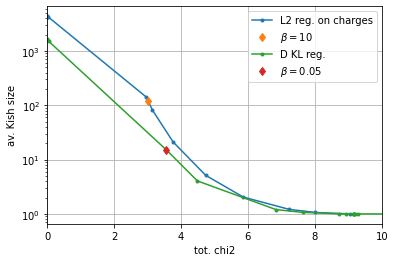

In [20]:
# s = 'D_KL tot' 
# s = 'kish ratio'
# s = 'Kish size tot'
s = 'av. Kish size'
# s = 'av. D_KL'

if s[:4] == 'av. ':
    cols = ['%s %s' % (s[4:], sys_name) for sys_name in sys_names]
    df[s] = np.mean(df[cols], axis=1)
    df2[s] = np.mean(df2[cols], axis=1)

plt.plot(df['chi2 tot'], df[s], '.-', label='L2 reg. on charges')
plt.plot(df['chi2 tot'][10], df[s][10], 'd', label=r'$\beta=10$')

plt.plot(df2['chi2 tot'], df2[s], '.-', label='D KL reg.')
plt.plot(df2['chi2 tot'][0.05], df2[s][0.05], 'd', label=r'$\beta=0.05$')

# plt.xscale('log')
plt.yscale('log')
plt.grid()
# plt.title('relative entropy reg.')
plt.xlabel('tot. chi2')
plt.ylabel('av. Kish size')
plt.xlim([0, 10])  # right=10)
plt.legend()
# plt.savefig('../../Figures/alchemical_DKL_kish_vs_chi2.png')
# plt.savefig('../../Figures/alchemical_Kishsize_vs_chi2.png')

In [78]:
for beta in betas:
    print(np.mean(list(kish_size_DKL[beta].values())))

1665.314117506709
1644.2594442951329
1501.6306580133046
15.116076556304673
4.04792421926548
1.2004402733268988
1.0673832937831154
1.0045003281603422
1.001373528349728
1.000233986706936
1.0001937320277279
1.0001711671881828
1.0001594860826075
1.0000988632921526
1.0000616607490442
1.0000085350197385
1.0000026760611676
1.0000001309000188
1.0000000336071693
1.000000001373543


In [68]:
[np.sum(list(kish_ratio_DKL[beta].values())) for beta in betas]

[0.12473156895198034,
 0.12473156895198034,
 0.12473156895198034,
 0.12473156895198034,
 0.12473156895198034,
 0.12473156895198034,
 0.12473156895198034,
 0.12473156895198034,
 0.12473156895198034,
 0.12473156895198034,
 0.12473156895198034,
 0.12473156895198034,
 0.12473156895198034,
 0.12473156895198034,
 0.12473156895198034,
 0.12473156895198034,
 0.12473156895198034,
 0.12473156895198034,
 0.12473156895198034,
 0.12473156895198034]

In [21]:
coeffs = pandas.read_csv('../../Results/alchemical_calculations/coefficients_L2charges', index_col=0)
coeffs2 = pandas.read_csv('../../Results/alchemical_calculations/coefficients_DKL', index_col=0)

names_charges = ['C6', 'N6', 'H61', 'N1', 'C10', 'H101/2/3']

In [64]:
coeffs2

,N6 (e),H61 (e),N1 (e),C10 (e),H101/2/3 (e),C6 (e),"$V_\eta \, (kJ/mol)$"
0.001,5.724553e-01,8.202707e-02,-7.837085e-03,-7.071218e-01,1.101724e-01,-2.700407e-01,-3.213463
0.005,5.531524e-01,8.610149e-02,-9.731094e-03,-7.036048e-01,1.123085e-01,-2.628434e-01,-3.145215
0.020,5.244995e-01,8.876669e-02,-9.974836e-03,-6.898741e-01,1.129725e-01,-2.523346e-01,-2.996725
0.050,2.708767e-01,1.997841e-02,-8.731462e-03,-1.867834e-01,7.012177e-04,-9.744389e-02,0.576903
0.100,2.053196e-01,4.479392e-03,-7.084074e-03,-8.715464e-02,-1.406361e-02,-7.336944e-02,1.069647
0.500,8.736746e-02,-7.635570e-03,-9.636548e-03,-2.557517e-02,-8.022306e-03,-2.045325e-02,1.421116
1.000,5.395764e-02,-6.747756e-03,-8.476213e-03,-1.334499e-02,-5.231695e-03,-9.693595e-03,1.471372
5.000,1.407173e-02,-2.539350e-03,-3.335327e-03,-2.507813e-03,-1.453151e-03,-1.329781e-03,1.486767
10.000,7.344347e-03,-1.401054e-03,-1.864355e-03,-1.203430e-03,-7.693731e-04,-5.673886e-04,1.482242
50.000,1.476421e-03,-2.890375e-04,-3.981789e-04,-2.134990e-04,-1.616811e-04,-9.066226e-05,1.472463


##### final figures

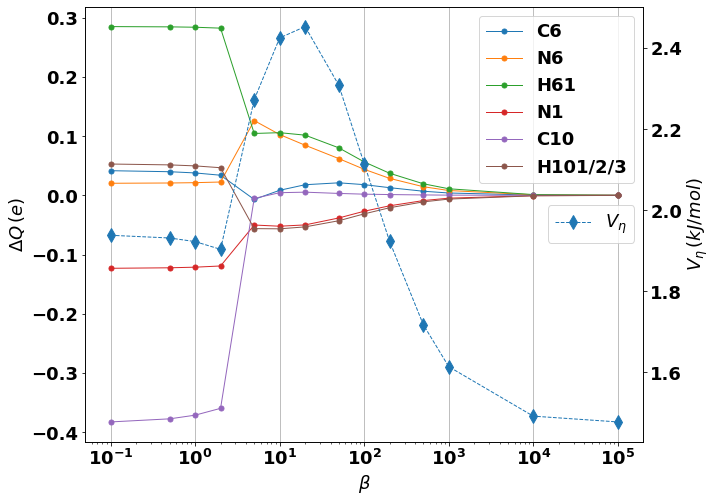

In [22]:
font = {'weight' : 'bold', 'size' : 18}

matplotlib.rc('font', **font)
matplotlib.rcParams['lines.linewidth'] = 1
matplotlib.rcParams['lines.markersize'] = 10

fig, ax1 = plt.subplots(figsize=(10, 8))

ax2 = ax1.twinx()

betas = coeffs.index

for name in names_charges:
    ax1.plot(betas, coeffs[name + ' (e)'], '.-', label=name)

ax2.plot(betas, coeffs['$V_\eta (kJ/mol)$'], 'd--', label='$V_\eta$')

ax1.set_xscale('log')
# ax1.set_yscale('symlog')
ax1.set_xlabel(r'$\beta$')
ax1.grid(axis='x')

ax1.set_ylabel('$\Delta Q \, (e)$')
ax2.set_ylabel('$V_\eta \, (kJ/mol)$')

# ax1.set_ylim([-0.45, 0.35])
# ax2.set_ylim([1.4, 2.5])

ax1.legend()#loc='lower right')
ax2.legend(loc='center right')

# min_y, max_y = ax2.get_ylim()
# opt_beta = 5e-2 # 5e-2 for DKL regularization and 10 for L2 reg.
# ax2.plot([opt_beta, opt_beta], [min_y, max_y], '-k', linewidth=1.5)
# ax2.set_ylim([min_y, max_y])

# plt.savefig('../../Figures/alchemical_fig1a.png')

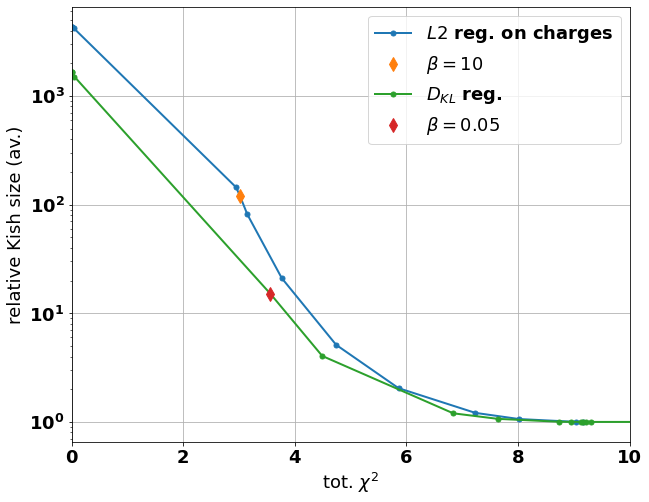

In [23]:
font = {'weight' : 'bold', 'size' : 18}

matplotlib.rc('font', **font)
matplotlib.rcParams['lines.linewidth'] = 1
matplotlib.rcParams['lines.markersize'] = 10

plt.subplots(figsize=(10, 8))

# s = 'D_KL tot' 
# s = 'kish ratio'
# s = 'Kish size tot'
s = 'av. Kish size'
# s = 'av. D_KL'

if s[:4] == 'av. ':
    cols = ['%s %s' % (s[4:], sys_name) for sys_name in sys_names]
    df[s] = np.mean(df[cols], axis=1)
    df2[s] = np.mean(df2[cols], axis=1)

plt.plot(df['chi2 tot'], df[s], '.-', linewidth=2, label='$L2$ reg. on charges')
plt.plot(df['chi2 tot'][10], df[s][10], 'd', label=r'$\beta=10$')

plt.plot(df2['chi2 tot'], df2[s], '.-', linewidth=2, label='$D_{KL}$ reg.')
plt.plot(df2['chi2 tot'][0.05], df2[s][0.05], 'd', label=r'$\beta=0.05$')

# plt.xscale('log')
plt.yscale('log')
plt.grid()
# plt.title('relative entropy reg.')
plt.xlabel('tot. $\chi^2$')
plt.ylabel('relative Kish size (av.)')
plt.xlim([0, 10])  # right=10)
plt.legend()
# plt.savefig('../../Figures/alchemical_fig3.png')

In [90]:
df = pandas.DataFrame(coeffs.loc[10])
df.columns = ['delta L2']

df['delta DKL'] = coeffs2.loc[0.05]
df['delta DKL'].loc['$V_\eta (kJ/mol)$'] = coeffs2.loc[0.05, '$V_\eta \, (kJ/mol)$']

df['Aduri'] = [-0.30623, 0.28948, -0.67597, -0.28897, 0.12596, 0.44911, None]
df['Krepl'] = [-0.4756, 0.3232, -0.6604, -0.0774, -0.0774, 0.5597, None]

df['L2'] = df['delta L2'] + df['Aduri']
df['DKL'] = df['delta DKL'] + df['Aduri']

df['L2'].iloc[-1] = df['delta L2'].iloc[-1]
df['DKL'].iloc[-1] = df['delta DKL'].iloc[-1]

df['Aduri'].iloc[-1] = 0
df['Krepl'].iloc[-1] = 0

# df.to_csv('../../Results/alchemical_calculations/comparison_coefficients')

In [35]:
df = pandas.read_csv('../../Results/alchemical_calculations/comparison_coefficients', index_col=0)

df

,delta L2,delta DKL,Aduri,Krepl,L2,DKL
N6 (e),0.102733,0.270877,-0.30623,-0.4756,-0.203497,-0.035353
H61 (e),0.105882,0.019978,0.28948,0.3232,0.395362,0.309458
N1 (e),-0.052120,-0.008731,-0.67597,-0.6604,-0.728090,-0.684701
C10 (e),0.004504,-0.186783,-0.28897,-0.0774,-0.284466,-0.475753
H101/2/3 (e),-0.056518,0.000701,0.12596,-0.0774,0.069442,0.126661
C6 (e),0.008557,-0.097444,0.44911,0.5597,0.457667,0.351666
$V_\eta (kJ/mol)$,2.425136,0.576903,0.00000,0.0000,2.425136,0.576903


In [25]:
def plot_DataFrame(df):

        barWidth = 1/(len(df.columns) + 1)

        fig = plt.subplots(figsize=(10, 8)) 

        brs = []
        brs.append(np.arange(len(df.iloc[:, 0])))
 
        plt.bar(brs[-1], df.iloc[:, 0], label = df.columns[0], width = barWidth) # edgecolor ='grey', color ='tab:blue')

        for i in range(1, len(df.columns)):
                brs.append([x + barWidth for x in brs[-1]])
                plt.bar(brs[-1], df.iloc[:, i], label=df.columns[i], width = barWidth) # edgecolor ='grey', color ='tab:blue')

        plt.xticks([r + barWidth for r in range(len(df.iloc[:, 0]))], list(df.index))
        # plt.xlabel(list(df.index))
        
        # plt.xlabel('Branch', fontweight ='bold', fontsize = 15) 
        # plt.ylabel('Students passed', fontweight ='bold', fontsize = 15) 
        # plt.xticks([r + barWidth for r in range(len(df['Aduri'].iloc[:-1]))], names_charges)

        plt.legend()
        # plt.gca().xaxis.grid(True)
        # plt.grid()
        # plt.show()

        return

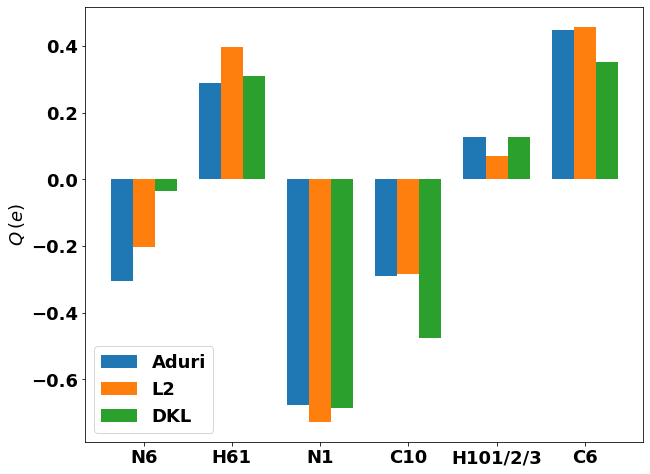

In [36]:
font = {'weight' : 'bold', 'size' : 18}

matplotlib.rc('font', **font)
matplotlib.rcParams['lines.linewidth'] = 1
matplotlib.rcParams['lines.markersize'] = 10

# plt.subplots(figsize=(10, 8))

df = df[['Aduri', 'L2', 'DKL']].iloc[:-1]
df.index = [s[:-4] for s in list(df.index)]

plot_DataFrame(df)

plt.ylabel('$Q \, (e)$')
# plt.savefig('../../Figures/alchemical_fig4a.png')


#### compute derivative of the KL divergence w.r.t. coefficients at optimal $\beta$

In [ ]:
coeffs_DKL_df = pandas.read_csv('../../Results/alchemical_calculations/coefficients_DKL', index_col=0)
coeffs = jnp.array(list(coeffs_DKL_df.loc[0.05].iloc[:5]) + [coeffs_DKL_df.loc[0.05].iloc[6]])

coeffs

DeviceArray([ 0.27087669,  0.01997841, -0.00873146, -0.1867834 ,
              0.00070122,  0.57690297], dtype=float64)

In [ ]:
def my_func(coeffs, data, sys_name, ff_correction):
    
    correction_ff = ff_correction(coeffs, data[sys_name].f)/data[sys_name].temperature
    weights_P, logZ_P = compute_new_weights(data[sys_name].weights, correction_ff)
    Dkl = compute_D_KL(weights_P, correction_ff, 1, logZ_P)

    return Dkl

In [ ]:
import jax

In [ ]:
jax_grad = jax.grad(my_func, argnums=0)

sys_names = ['A1_AS', 'A1_AD', 'A1_MS', 'A1_MD', 'A2_AS', 'A2_AD', 'A2_MS', 'A2_MD', 'A3_AS', 'A3_AD', 'A3_MS', 'A3_MD', 'A4_AS', 'A4_AD', 'A4_MS', 'A4_MD', 'A5_AS', 'A5_AD', 'A5_MS', 'A5_MD']
sys_names = [name for name in sys_names if name[-2] == 'M']

print(sys_names)

grad = {}
Dkl = {}

for name in sys_names:
    Dkl[name] = my_func(coeffs, data, name, ff_correction)
    grad[name] = jax_grad(coeffs, data, name, ff_correction)

['A1_MS', 'A1_MD', 'A2_MS', 'A2_MD', 'A3_MS', 'A3_MD', 'A4_MS', 'A4_MD', 'A5_MS', 'A5_MD']


In [ ]:
Dkl

{'A1_MS': DeviceArray(1.48091727, dtype=float64),
 'A1_MD': DeviceArray(1.25664621, dtype=float64),
 'A2_MS': DeviceArray(1.50562058, dtype=float64),
 'A2_MD': DeviceArray(1.08941255, dtype=float64),
 'A3_MS': DeviceArray(1.41727242, dtype=float64),
 'A3_MD': DeviceArray(1.05367131, dtype=float64),
 'A4_MS': DeviceArray(1.47420929, dtype=float64),
 'A4_MD': DeviceArray(1.31690617, dtype=float64),
 'A5_MS': DeviceArray(1.51991127, dtype=float64),
 'A5_MD': DeviceArray(1.37725713, dtype=float64)}

correct, since it is the same as the one previously computed

In [ ]:
pandas.read_csv('../../Results/alchemical_calculations/values_DKL', index_col=0).loc[0.05]

loss                 2.455869
kish ratio           0.078484
chi2s A1             0.568532
chi2s A2             2.215856
chi2s A3             0.545488
chi2s A4             0.049747
chi2s A5             0.182933
chi2 tot             3.562556
D_KL tot            13.491824
Kish size tot      151.160766
Kish size A1_MS     18.539783
D_KL A1_MS           1.480917
Kish size A1_MD     11.093572
D_KL A1_MD           1.256646
Kish size A2_MS     25.957253
D_KL A2_MS           1.505621
Kish size A2_MD      8.933479
D_KL A2_MD           1.089413
Kish size A3_MS     15.956294
D_KL A3_MS           1.417272
Kish size A3_MD      7.840894
D_KL A3_MD           1.053671
Kish size A4_MS     14.566398
D_KL A4_MS           1.474209
Kish size A4_MD     10.868050
D_KL A4_MD           1.316906
Kish size A5_MS     22.183385
D_KL A5_MS           1.519911
Kish size A5_MD     15.221658
D_KL A5_MD           1.377257
Name: 0.05, dtype: float64

Text(0.5, 1.0, 'derivatives of D_KL')

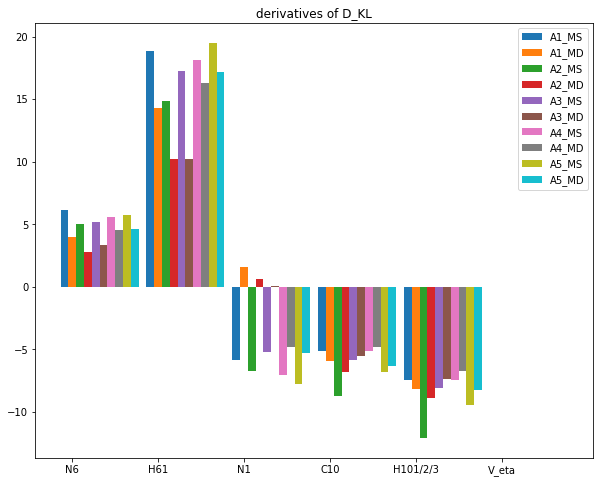

In [ ]:
df = pandas.DataFrame(grad)
df.index = names_charges + ['V_eta']
df.loc['H101/2/3'] = df.loc['H101/2/3']/3

plot_DataFrame(df)
plt.title('derivatives of D_KL')
# plt.savefig('../../Figures/alchemical_derivatives.png')